In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("./data_v9/result_data.csv")
df.head()

,average_rtt,packet_loss,bits_per_second,bu_ratio,retransmits,cpu_host_total,cpu_host_system,bidirectional_duration_ms,src2dst_duration_ms,dst2src_duration_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,traffic_type_numeric
0,1561.634,12.4,8.610895e+05,91.389105,143,3.749818,3.262176,17238,17238,14863,861.900000,1372.428002,5158,1567.090909,1555.220271,5158,1857.875000,2427.591483,7149,2
1,1579.960,11.2,1.042366e+06,89.576335,148,3.349446,2.801653,17120,17120,14704,901.052632,1411.346932,5220,1712.000000,1581.827424,5220,1838.000000,2470.896945,7226,2
2,1682.569,12.0,7.902393e+05,92.097607,122,3.632624,3.117006,16754,16754,14431,837.700000,1323.192237,4947,1523.090909,1494.077003,4947,1803.875000,2364.037795,6973,2
3,1571.672,11.4,6.201423e+05,93.798577,84,3.876580,3.381408,18048,18048,15656,902.400000,1427.875212,5104,1640.727273,1612.991388,5104,1957.000000,2537.372770,7358,2
4,1546.242,12.6,6.521823e+05,93.478177,90,3.774115,3.268269,19171,19171,16870,912.904762,1302.448844,4733,1742.818182,1987.855821,6934,1874.444444,1490.928160,4733,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   average_rtt                   876 non-null    float64
 1   packet_loss                   876 non-null    float64
 2   bits_per_second               876 non-null    float64
 3   bu_ratio                      876 non-null    float64
 4   retransmits                   876 non-null    int64  
 5   cpu_host_total                876 non-null    float64
 6   cpu_host_system               876 non-null    float64
 7   bidirectional_duration_ms     876 non-null    int64  
 8   src2dst_duration_ms           876 non-null    int64  
 9   dst2src_duration_ms           876 non-null    int64  
 10  bidirectional_mean_piat_ms    876 non-null    float64
 11  bidirectional_stddev_piat_ms  876 non-null    float64
 12  bidirectional_max_piat_ms     876 non-null    int64  
 13  src2d

In [4]:
df['traffic_type_numeric'] = df['traffic_type_numeric'].map(lambda x: 1 if x == 2 else 0)

# Verileri ayırma: 70% train, 15% validation, 15% test
train_data, temp_data = train_test_split(df, test_size=0.30, random_state=40)
validation_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=40)

In [5]:
# Özellikler ve hedef sütunu ayırma
X_train = train_data.drop('traffic_type_numeric', axis=1)
y_train = train_data['traffic_type_numeric']
X_val = validation_data.drop('traffic_type_numeric', axis=1)
y_val = validation_data['traffic_type_numeric']
X_test = test_data.drop('traffic_type_numeric', axis=1)
y_test = test_data['traffic_type_numeric']

<AxesSubplot:>

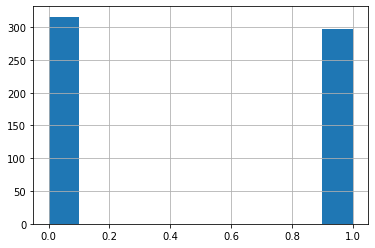

In [6]:
y_train.hist()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def print_classification_metrics(y_test, y_pred, y_pred_proba, average='binary'):
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'AUC: {auc:.3f}')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import numpy as np

sns.set(style="whitegrid", rc={"font.size":12,"axes.labelsize":12})

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    labels = ["Low-Traffic", "High-Traffic"]
    plt.figure(figsize=(8, 6), dpi=600)  
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)  
    plt.xlabel('Predicted Label', fontsize=14)  
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png') 
    plt.show()

def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6), dpi=600)  
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'Receiver Operating Characteristic for {model_name}', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc_curve.png') 
    plt.show()


# XGBOOST

[0]	validation_0-logloss:0.49783
[1]	validation_0-logloss:0.40417
[2]	validation_0-logloss:0.34168
[3]	validation_0-logloss:0.30466
[4]	validation_0-logloss:0.28449
[5]	validation_0-logloss:0.27337
[6]	validation_0-logloss:0.27275
[7]	validation_0-logloss:0.27744
[8]	validation_0-logloss:0.27513
[9]	validation_0-logloss:0.28190
[10]	validation_0-logloss:0.28752
[11]	validation_0-logloss:0.28938
[12]	validation_0-logloss:0.29457
[13]	validation_0-logloss:0.29679
[14]	validation_0-logloss:0.30691
[15]	validation_0-logloss:0.31507
[16]	validation_0-logloss:0.32418


C:\Users\fb-du\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Precision: 0.956
Recall: 0.956
F1 Score: 0.956
AUC: 0.954


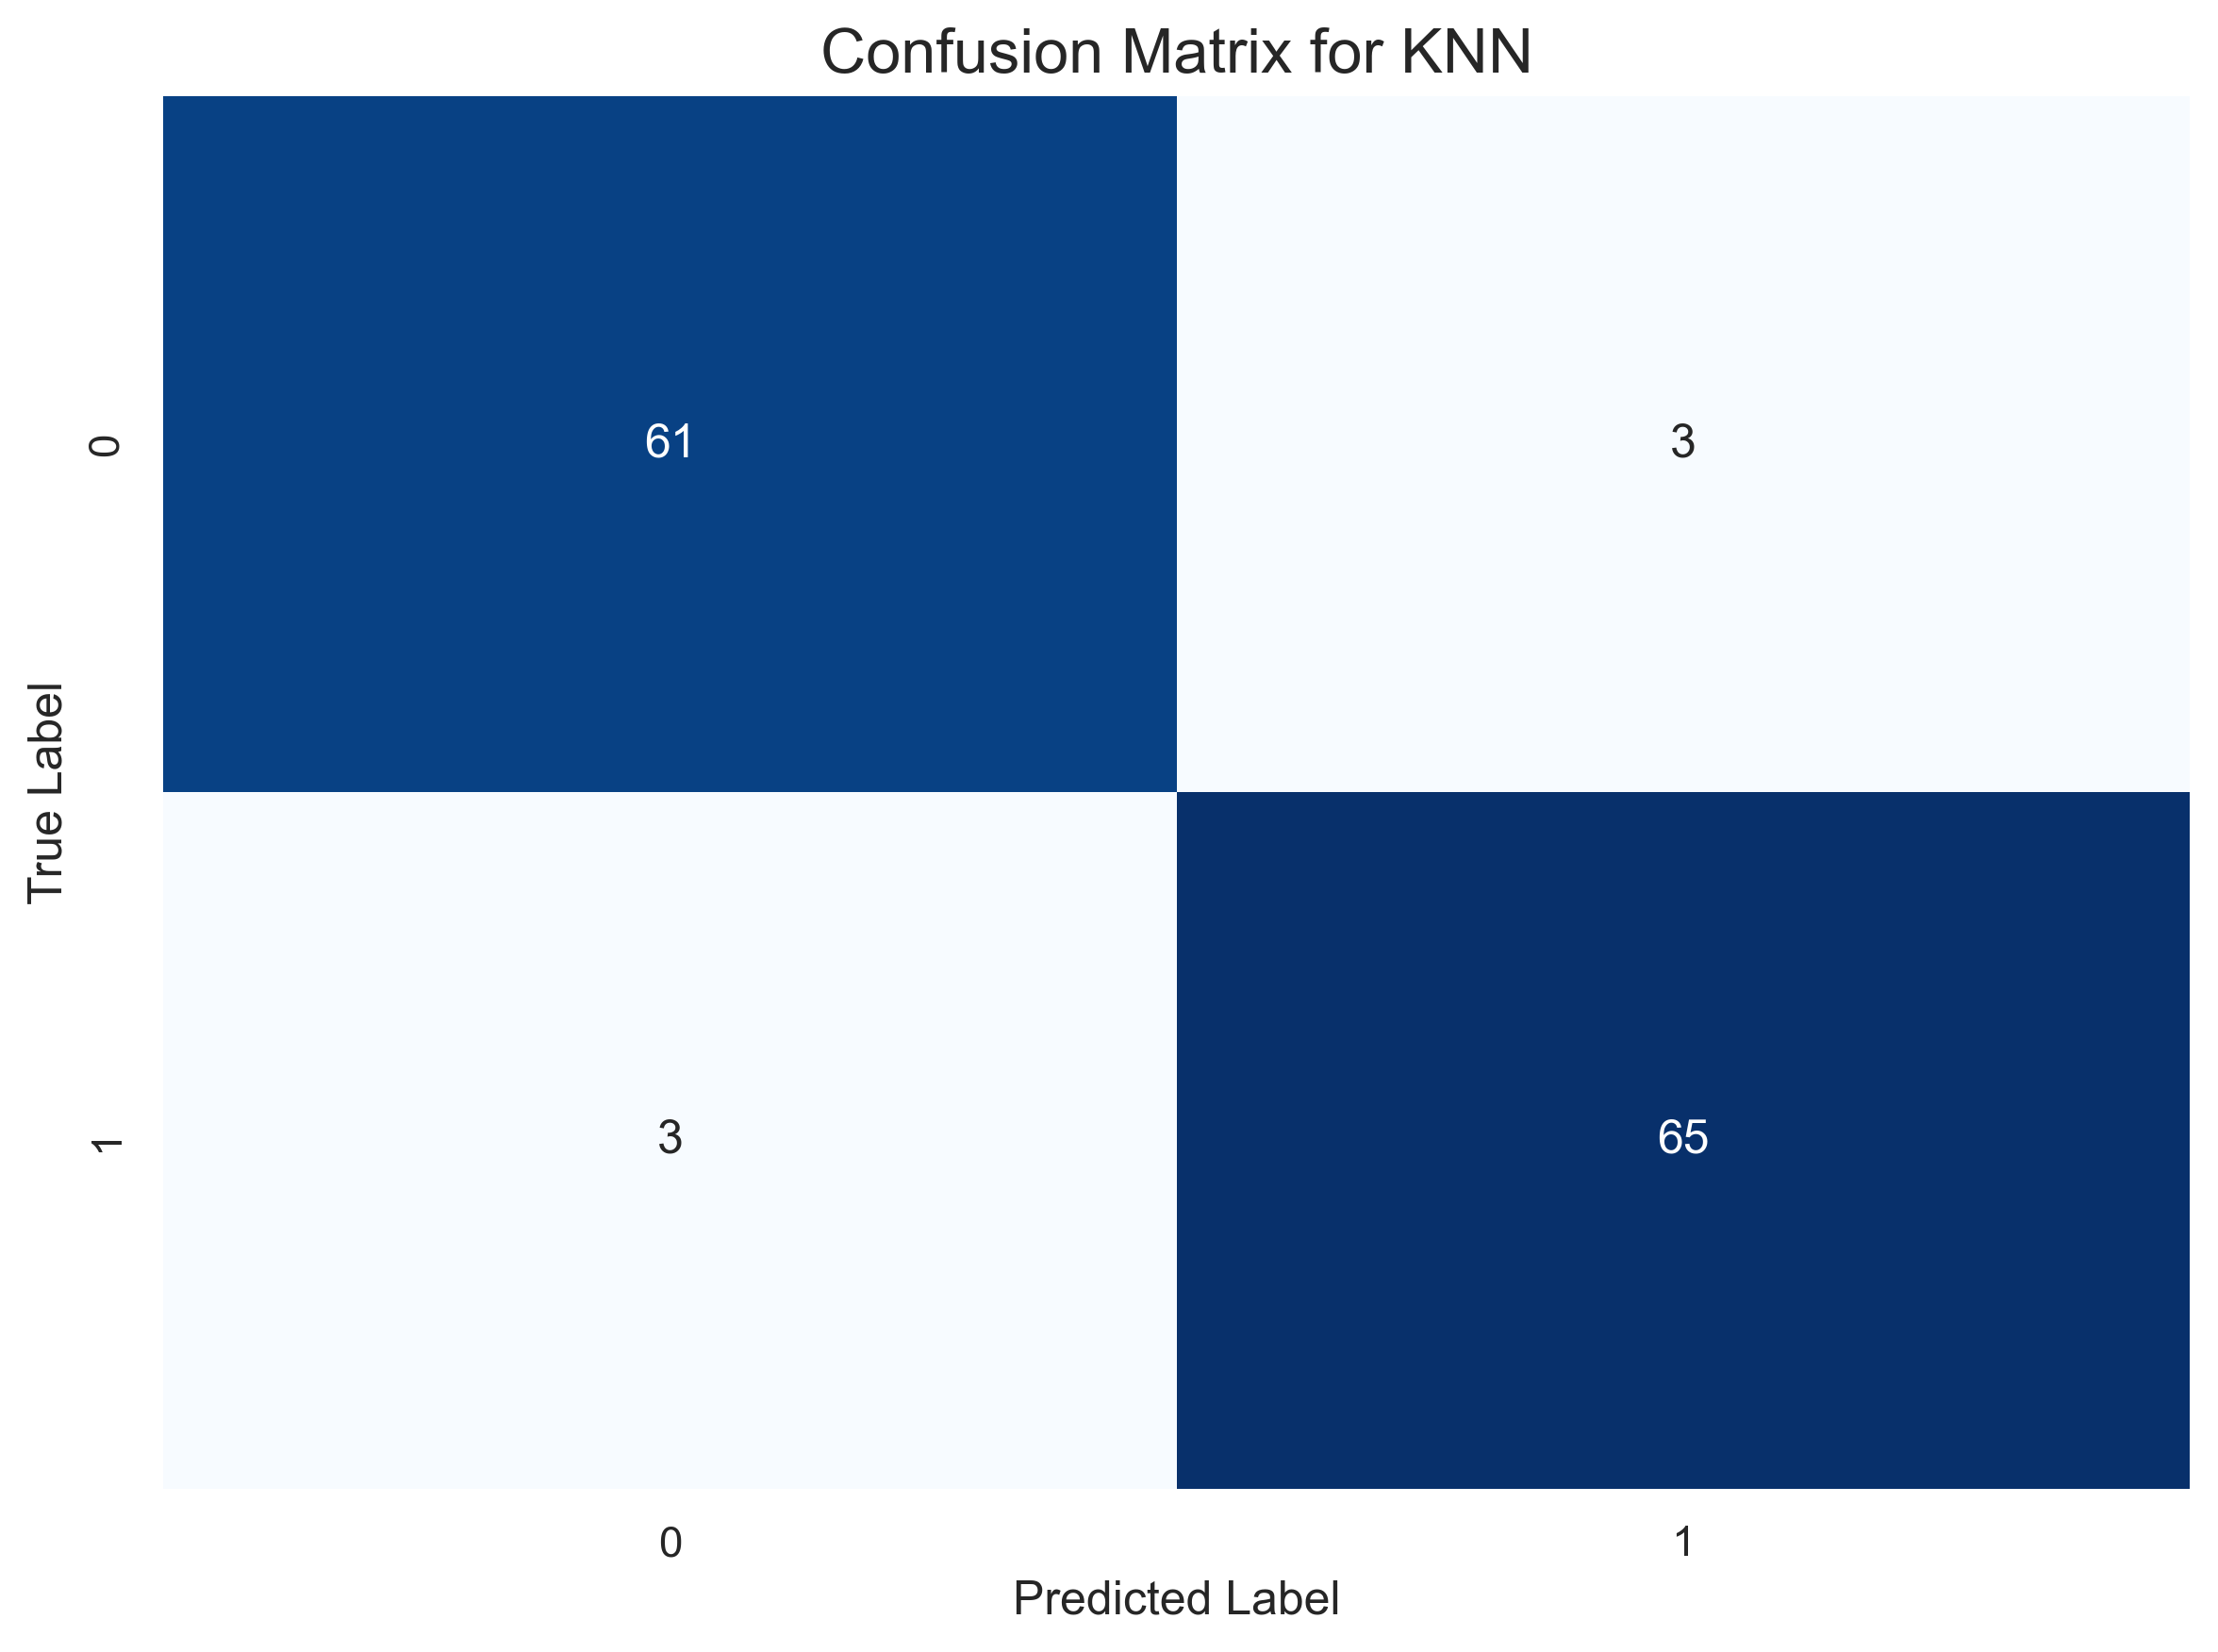

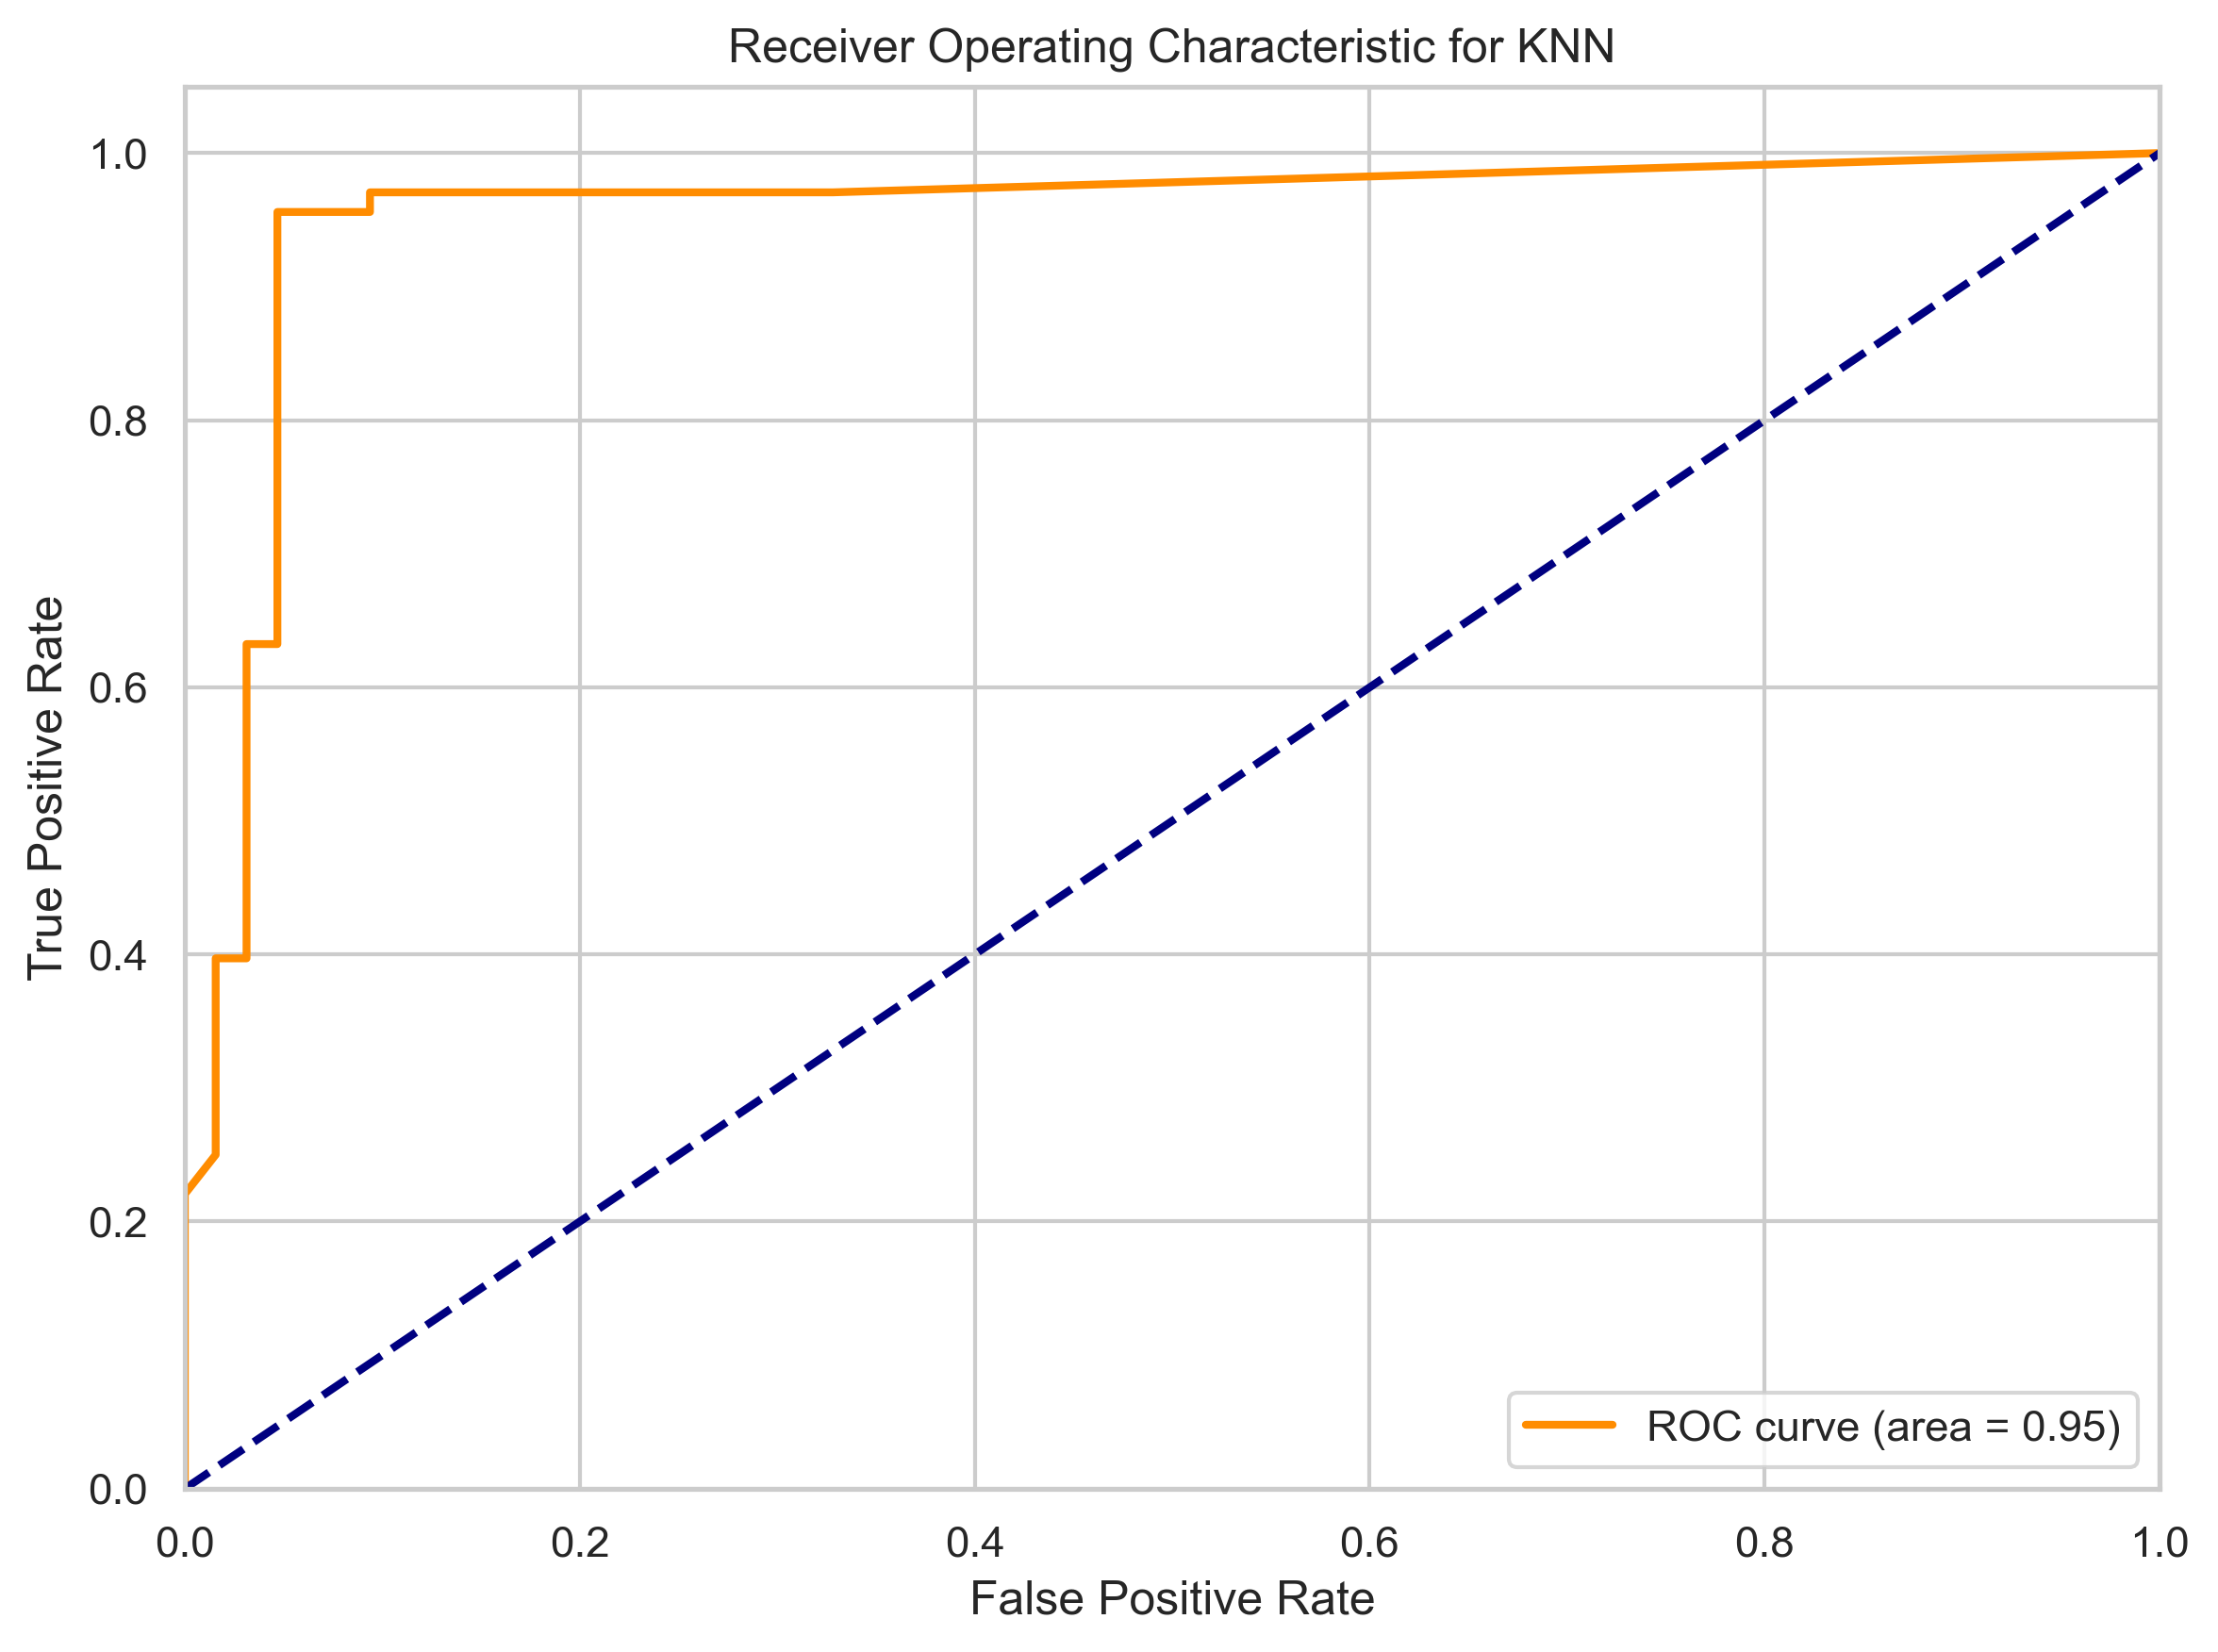

Classification Report:
               precision    recall  f1-score   support

           0      0.953     0.953     0.953        64
           1      0.956     0.956     0.956        68

    accuracy                          0.955       132
   macro avg      0.955     0.955     0.955       132
weighted avg      0.955     0.955     0.955       132



In [ ]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)
print_classification_metrics(y_test, y_pred, y_pred_proba)


plot_confusion_matrix(y_test, y_pred, "KNN")
plot_roc_curve(y_test, y_pred_proba, "KNN")

report = classification_report(y_test, y_pred, digits=3)
print("Classification Report:\n", report)

# Random Forest

Precision: 0.943
Recall: 0.971
F1 Score: 0.957
AUC: 0.955


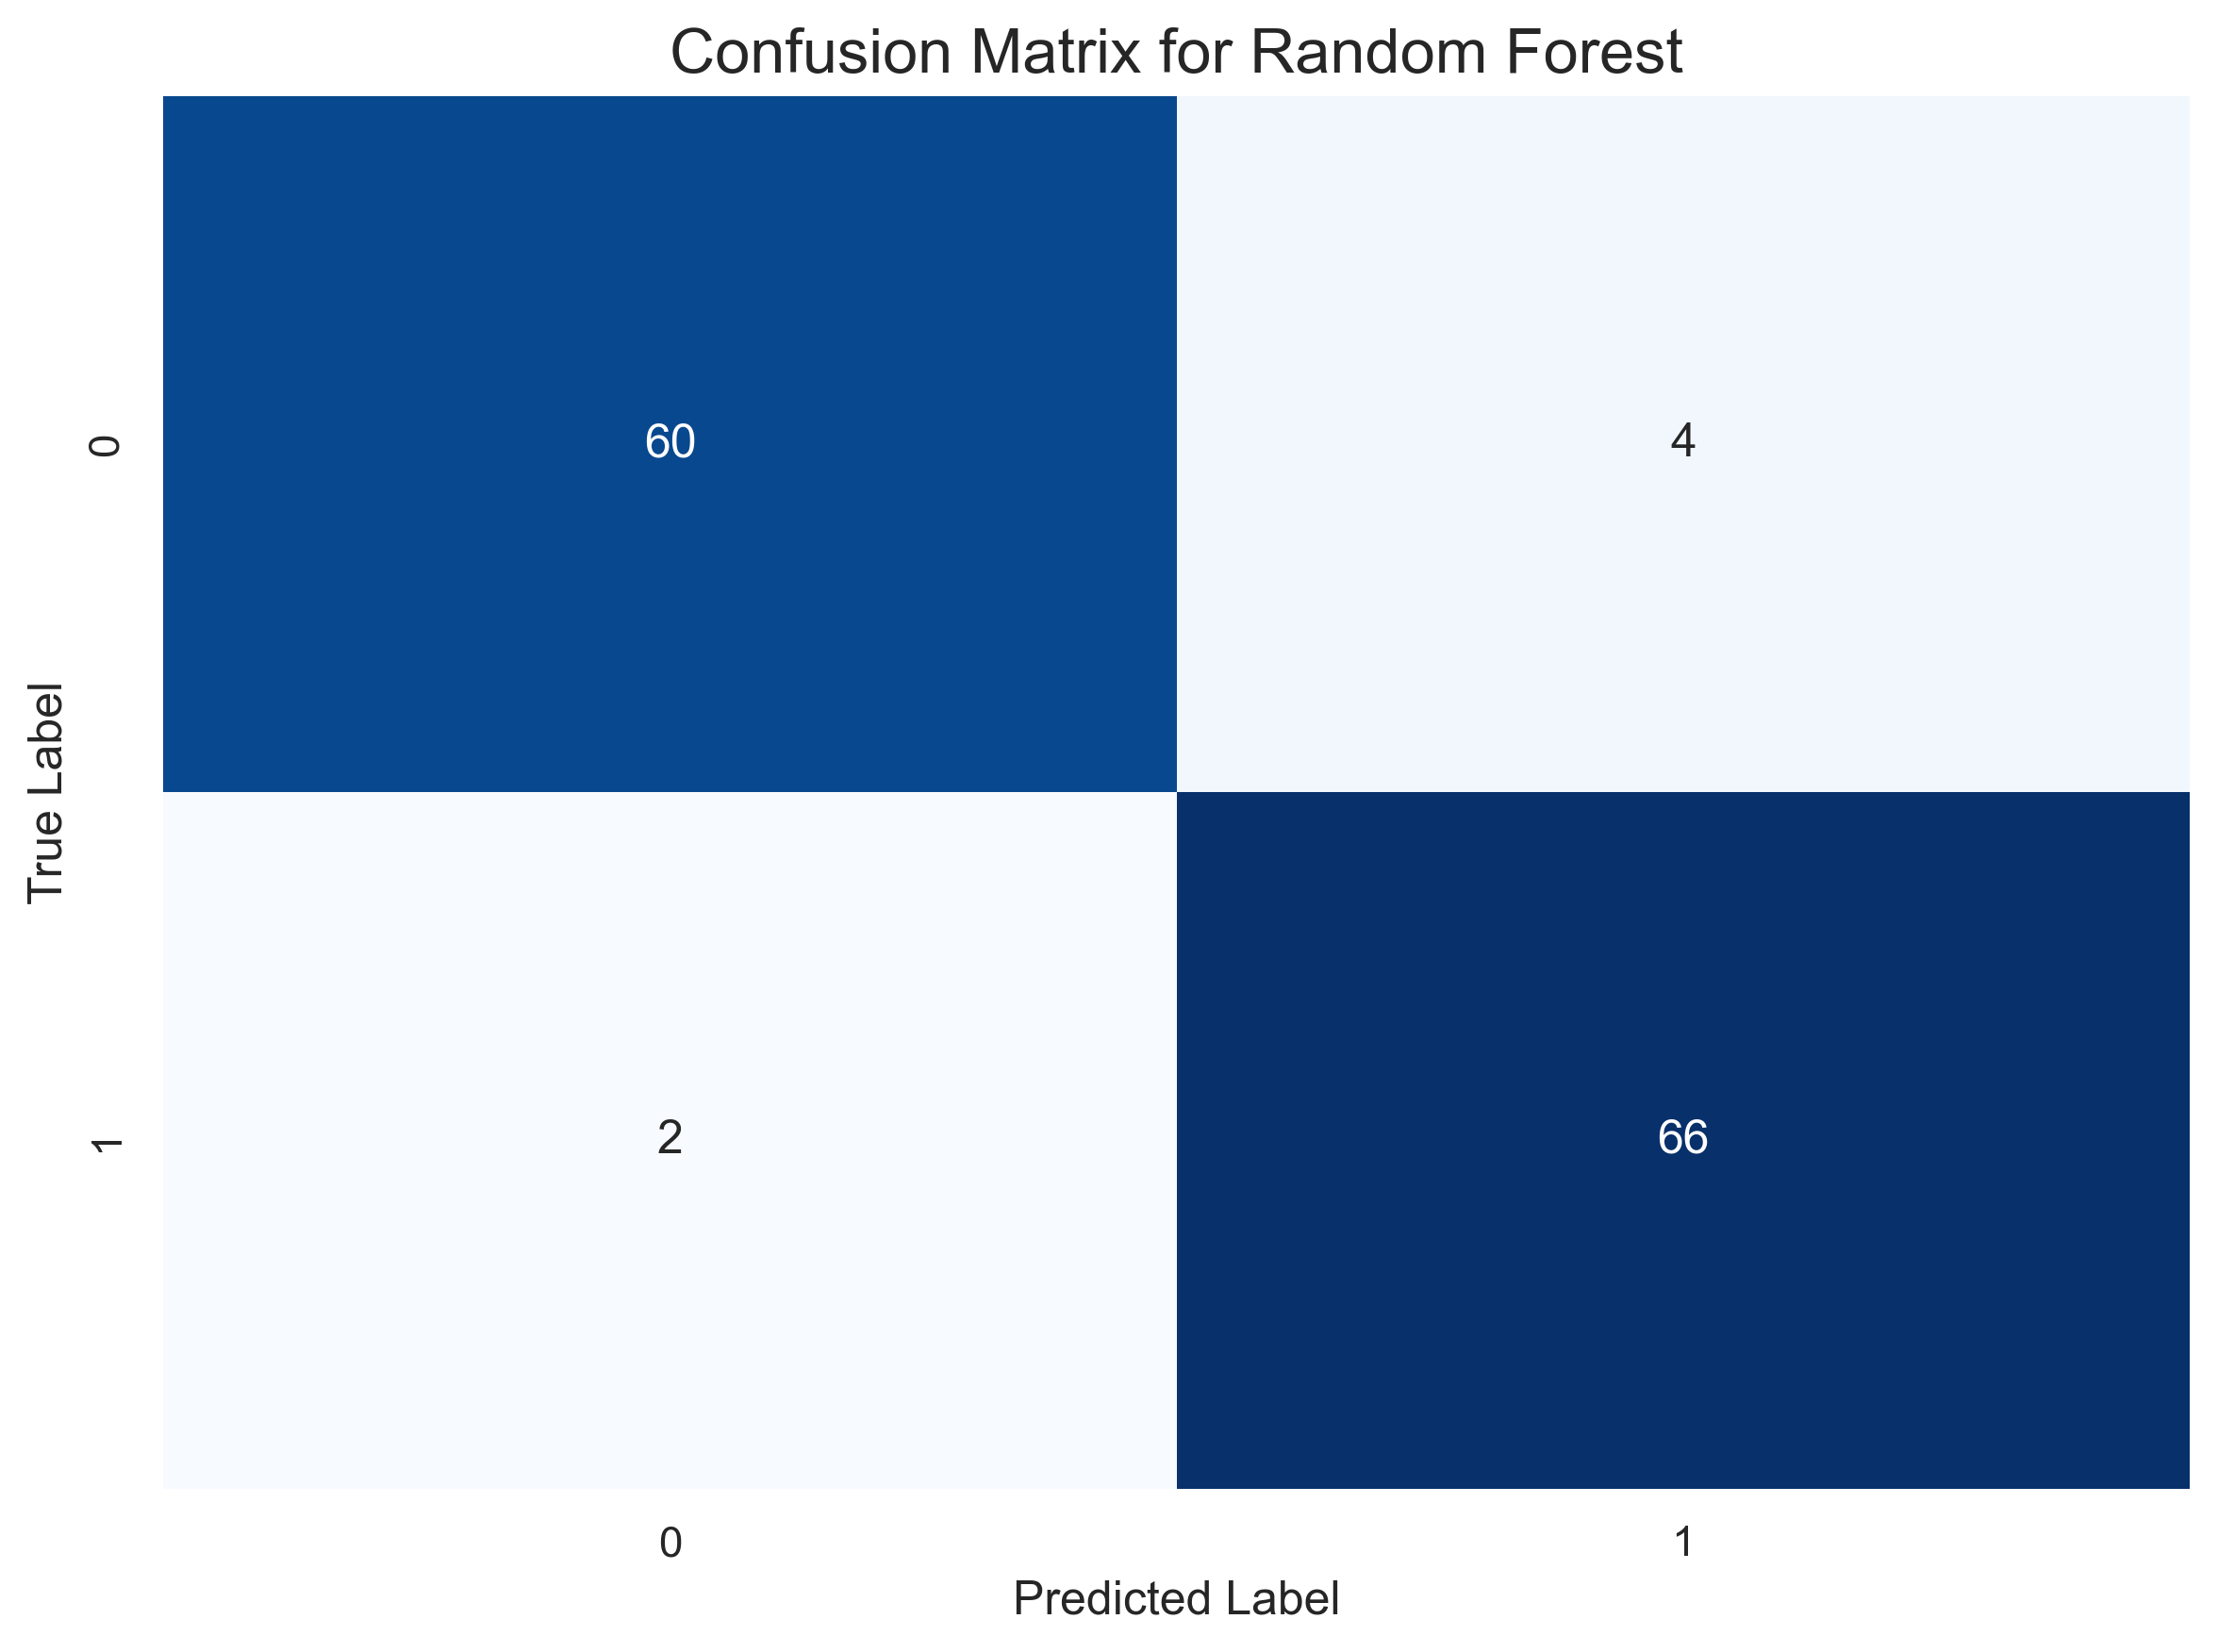

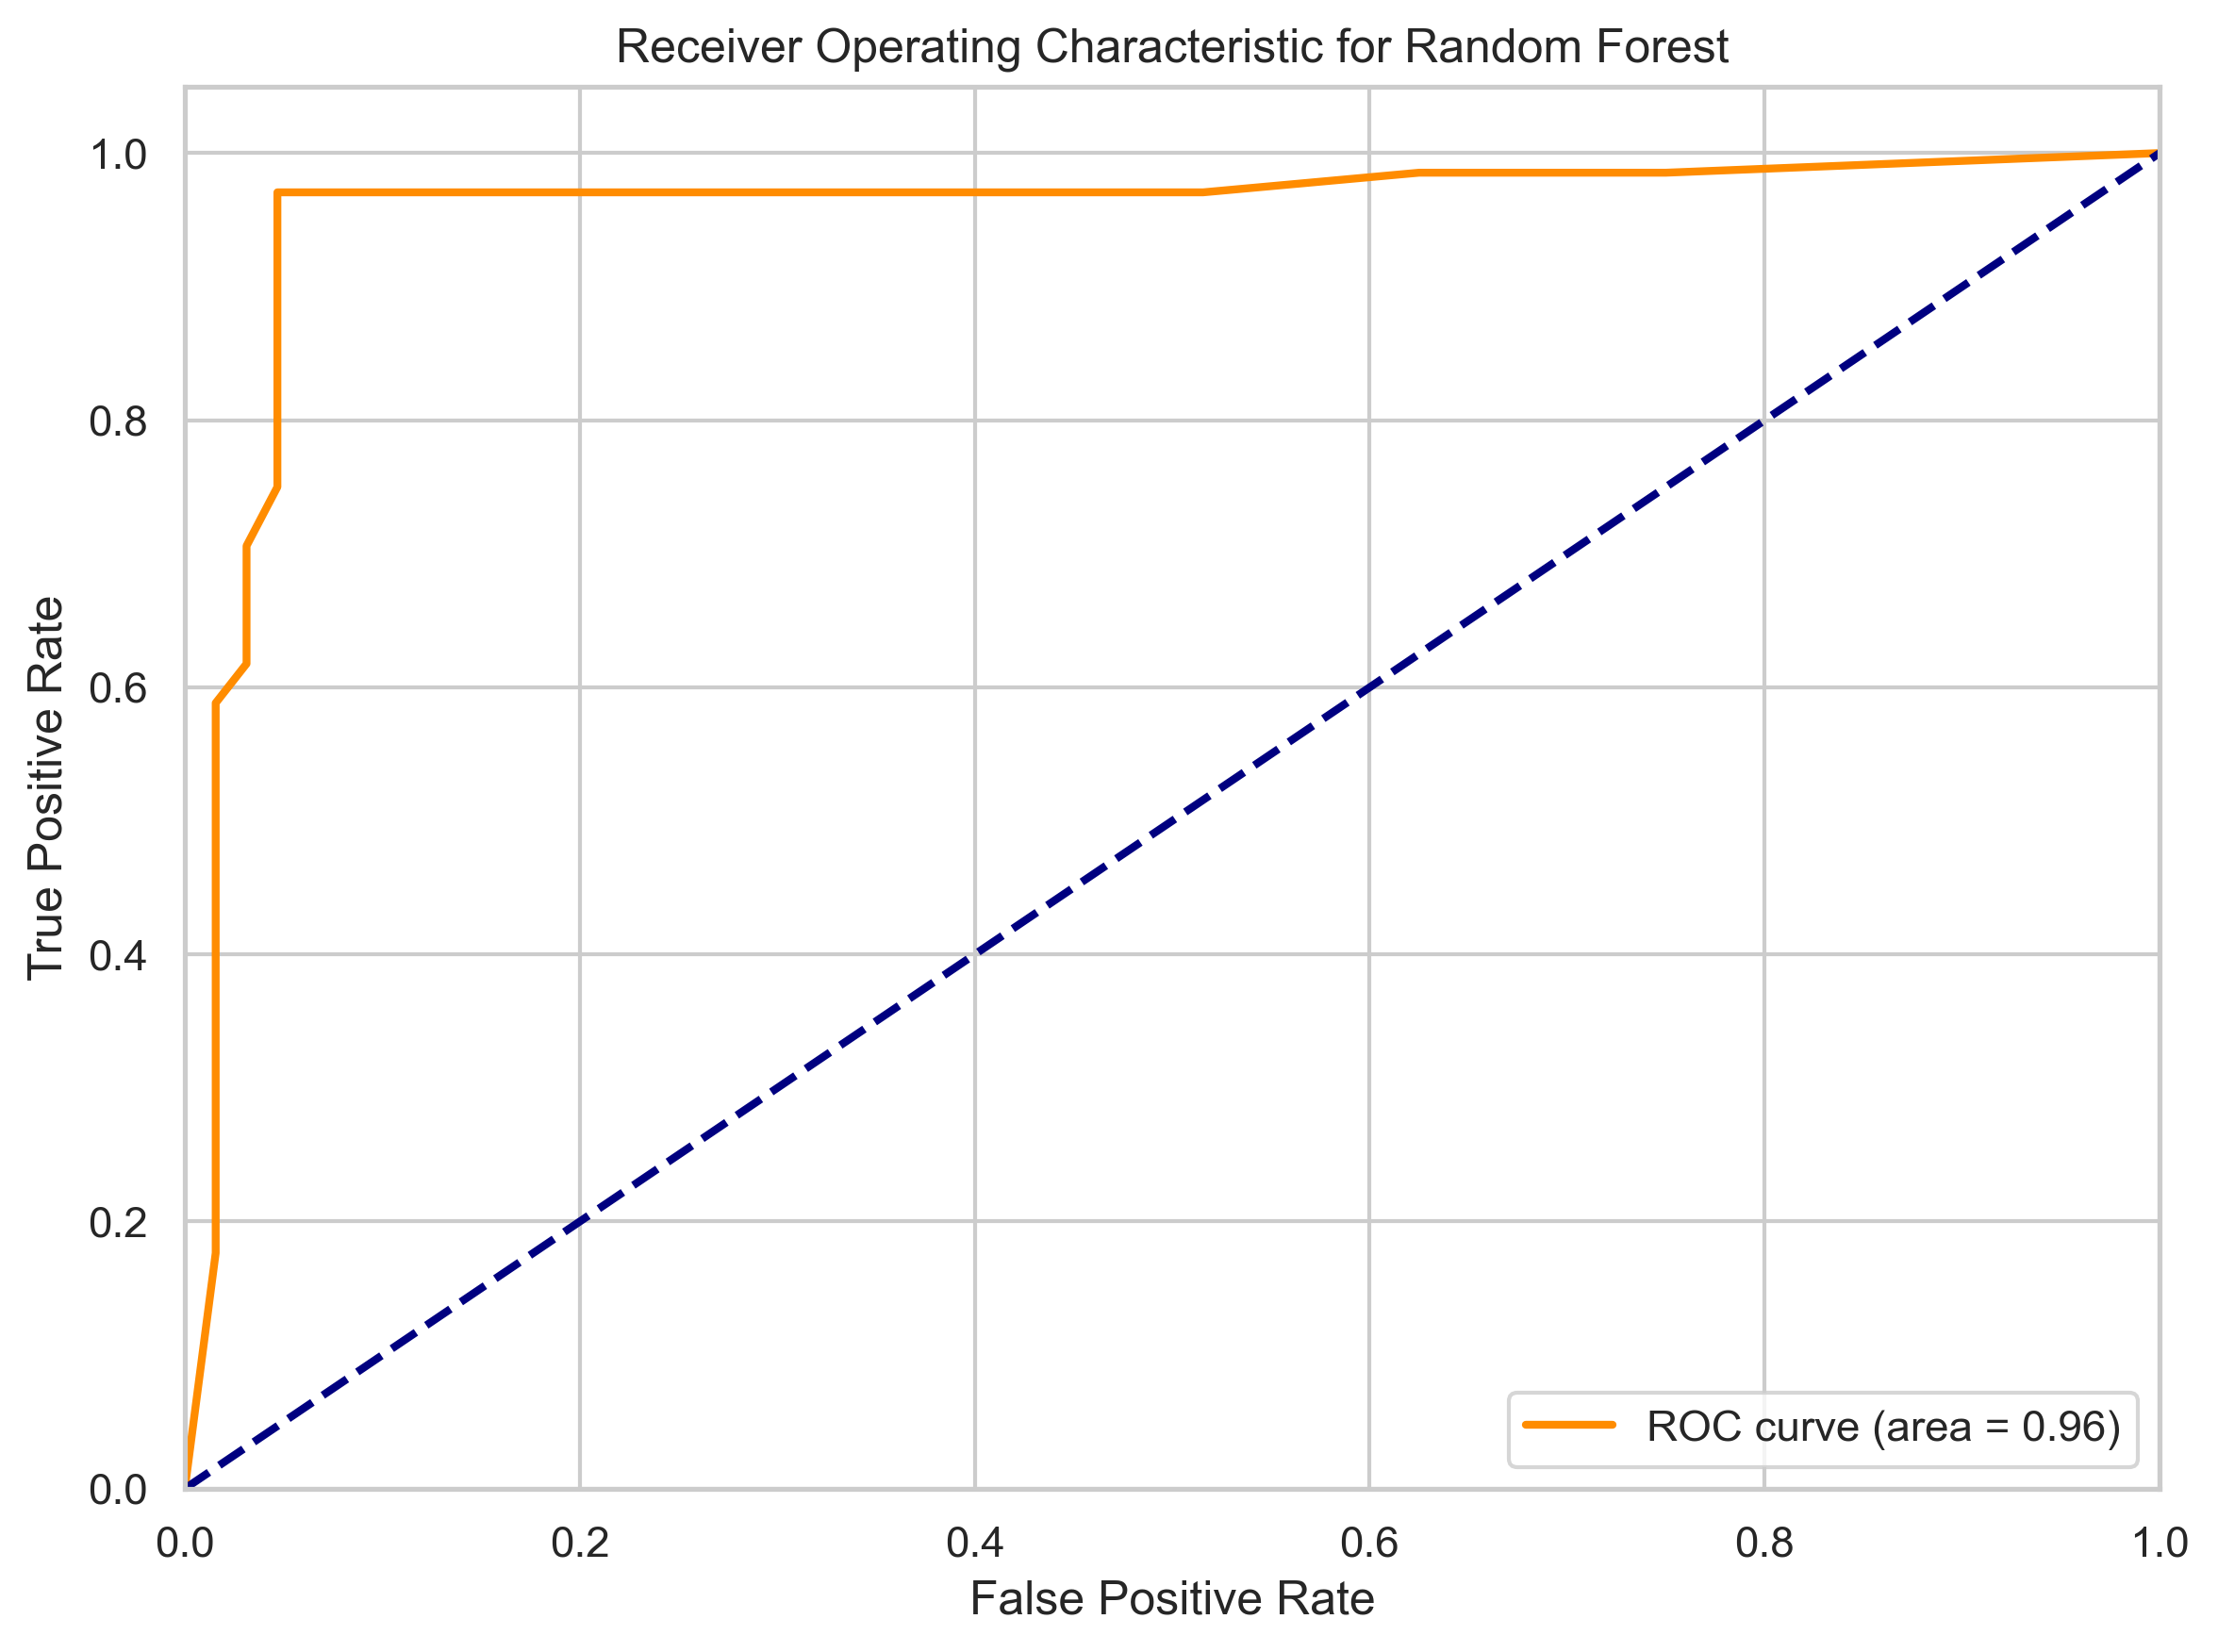

Classification Report:
               precision    recall  f1-score   support

           0      0.968     0.938     0.952        64
           1      0.943     0.971     0.957        68

    accuracy                          0.955       132
   macro avg      0.955     0.954     0.954       132
weighted avg      0.955     0.955     0.955       132



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)
print_classification_metrics(y_test, y_pred, y_pred_proba)

plot_confusion_matrix(y_test, y_pred, "Random Forest")
plot_roc_curve(y_test, y_pred_proba, "Random Forest")

report = classification_report(y_test, y_pred, digits=3)
print("Classification Report:\n", report)


# SVM

Precision: 0.955
Recall: 0.941
F1 Score: 0.948
AUC: 0.955


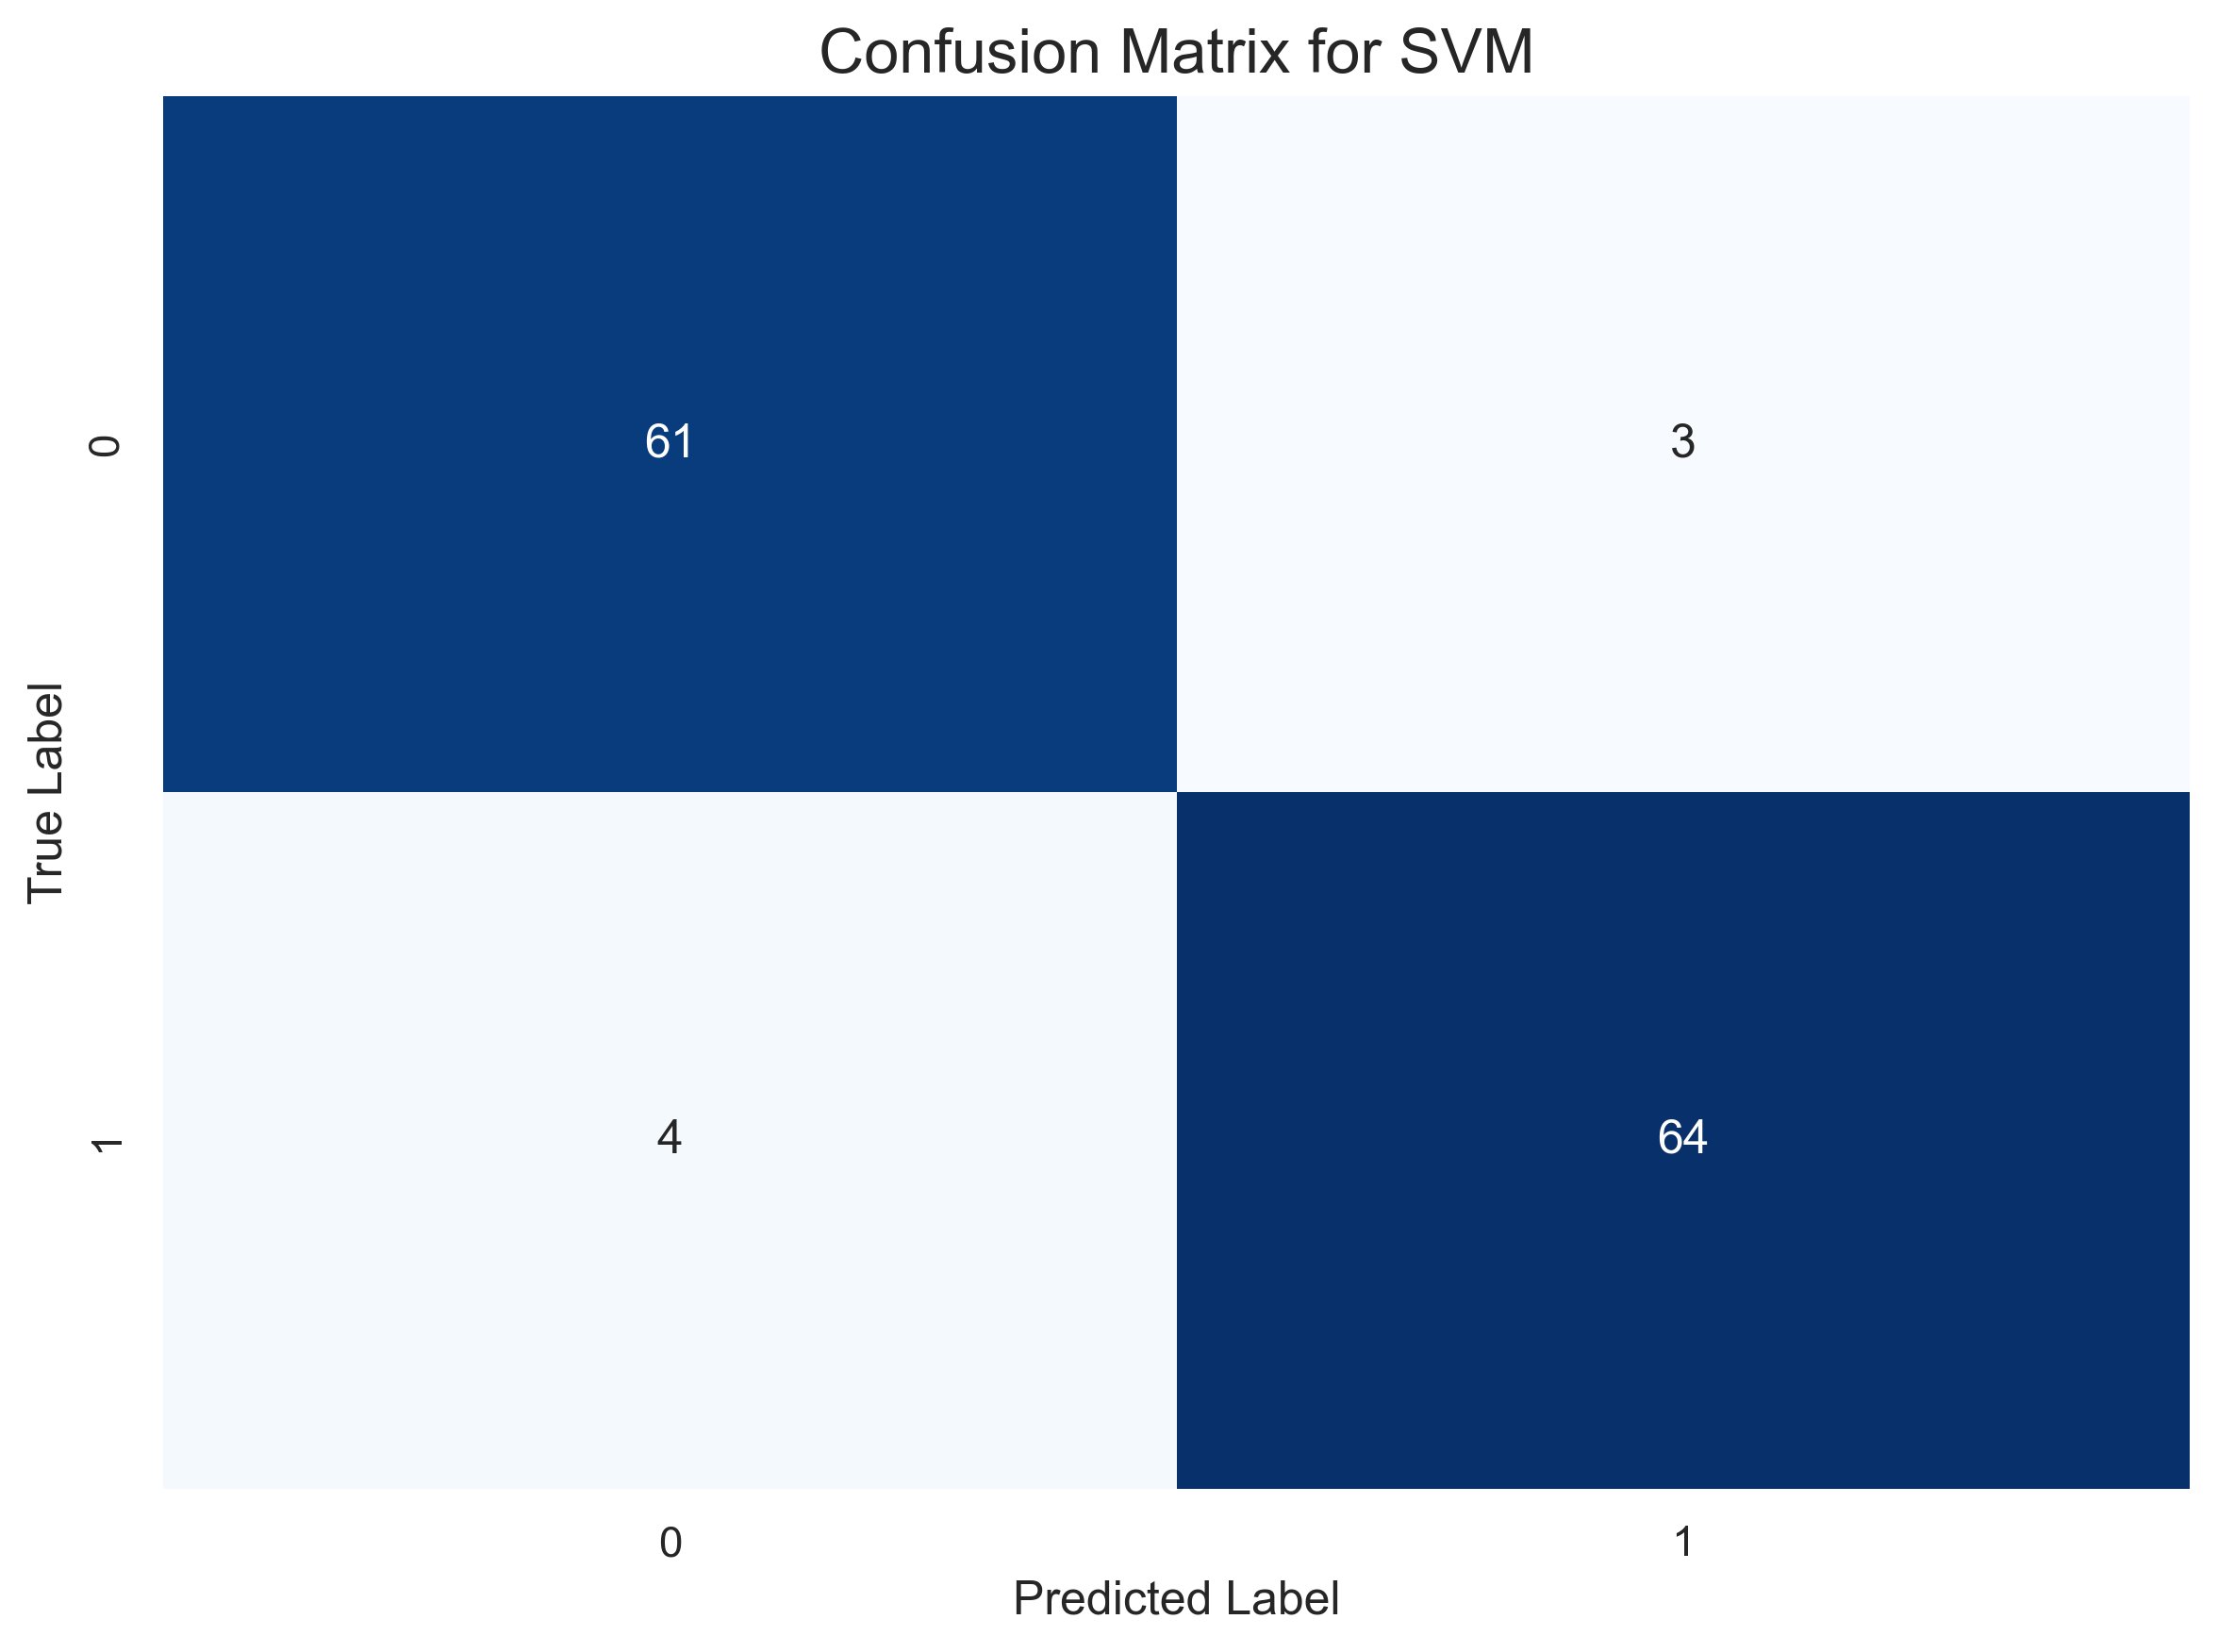

Classification Report:
               precision    recall  f1-score   support

           0      0.938     0.953     0.946        64
           1      0.955     0.941     0.948        68

    accuracy                          0.947       132
   macro avg      0.947     0.947     0.947       132
weighted avg      0.947     0.947     0.947       132



In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print_classification_metrics(y_test, y_pred, y_pred_proba)

plot_confusion_matrix(y_test, y_pred, "SVM")

report = classification_report(y_test, y_pred, digits=3)
print("Classification Report:\n", report)


# KNN

Precision: 0.917
Recall: 0.971
F1 Score: 0.943
AUC: 0.953


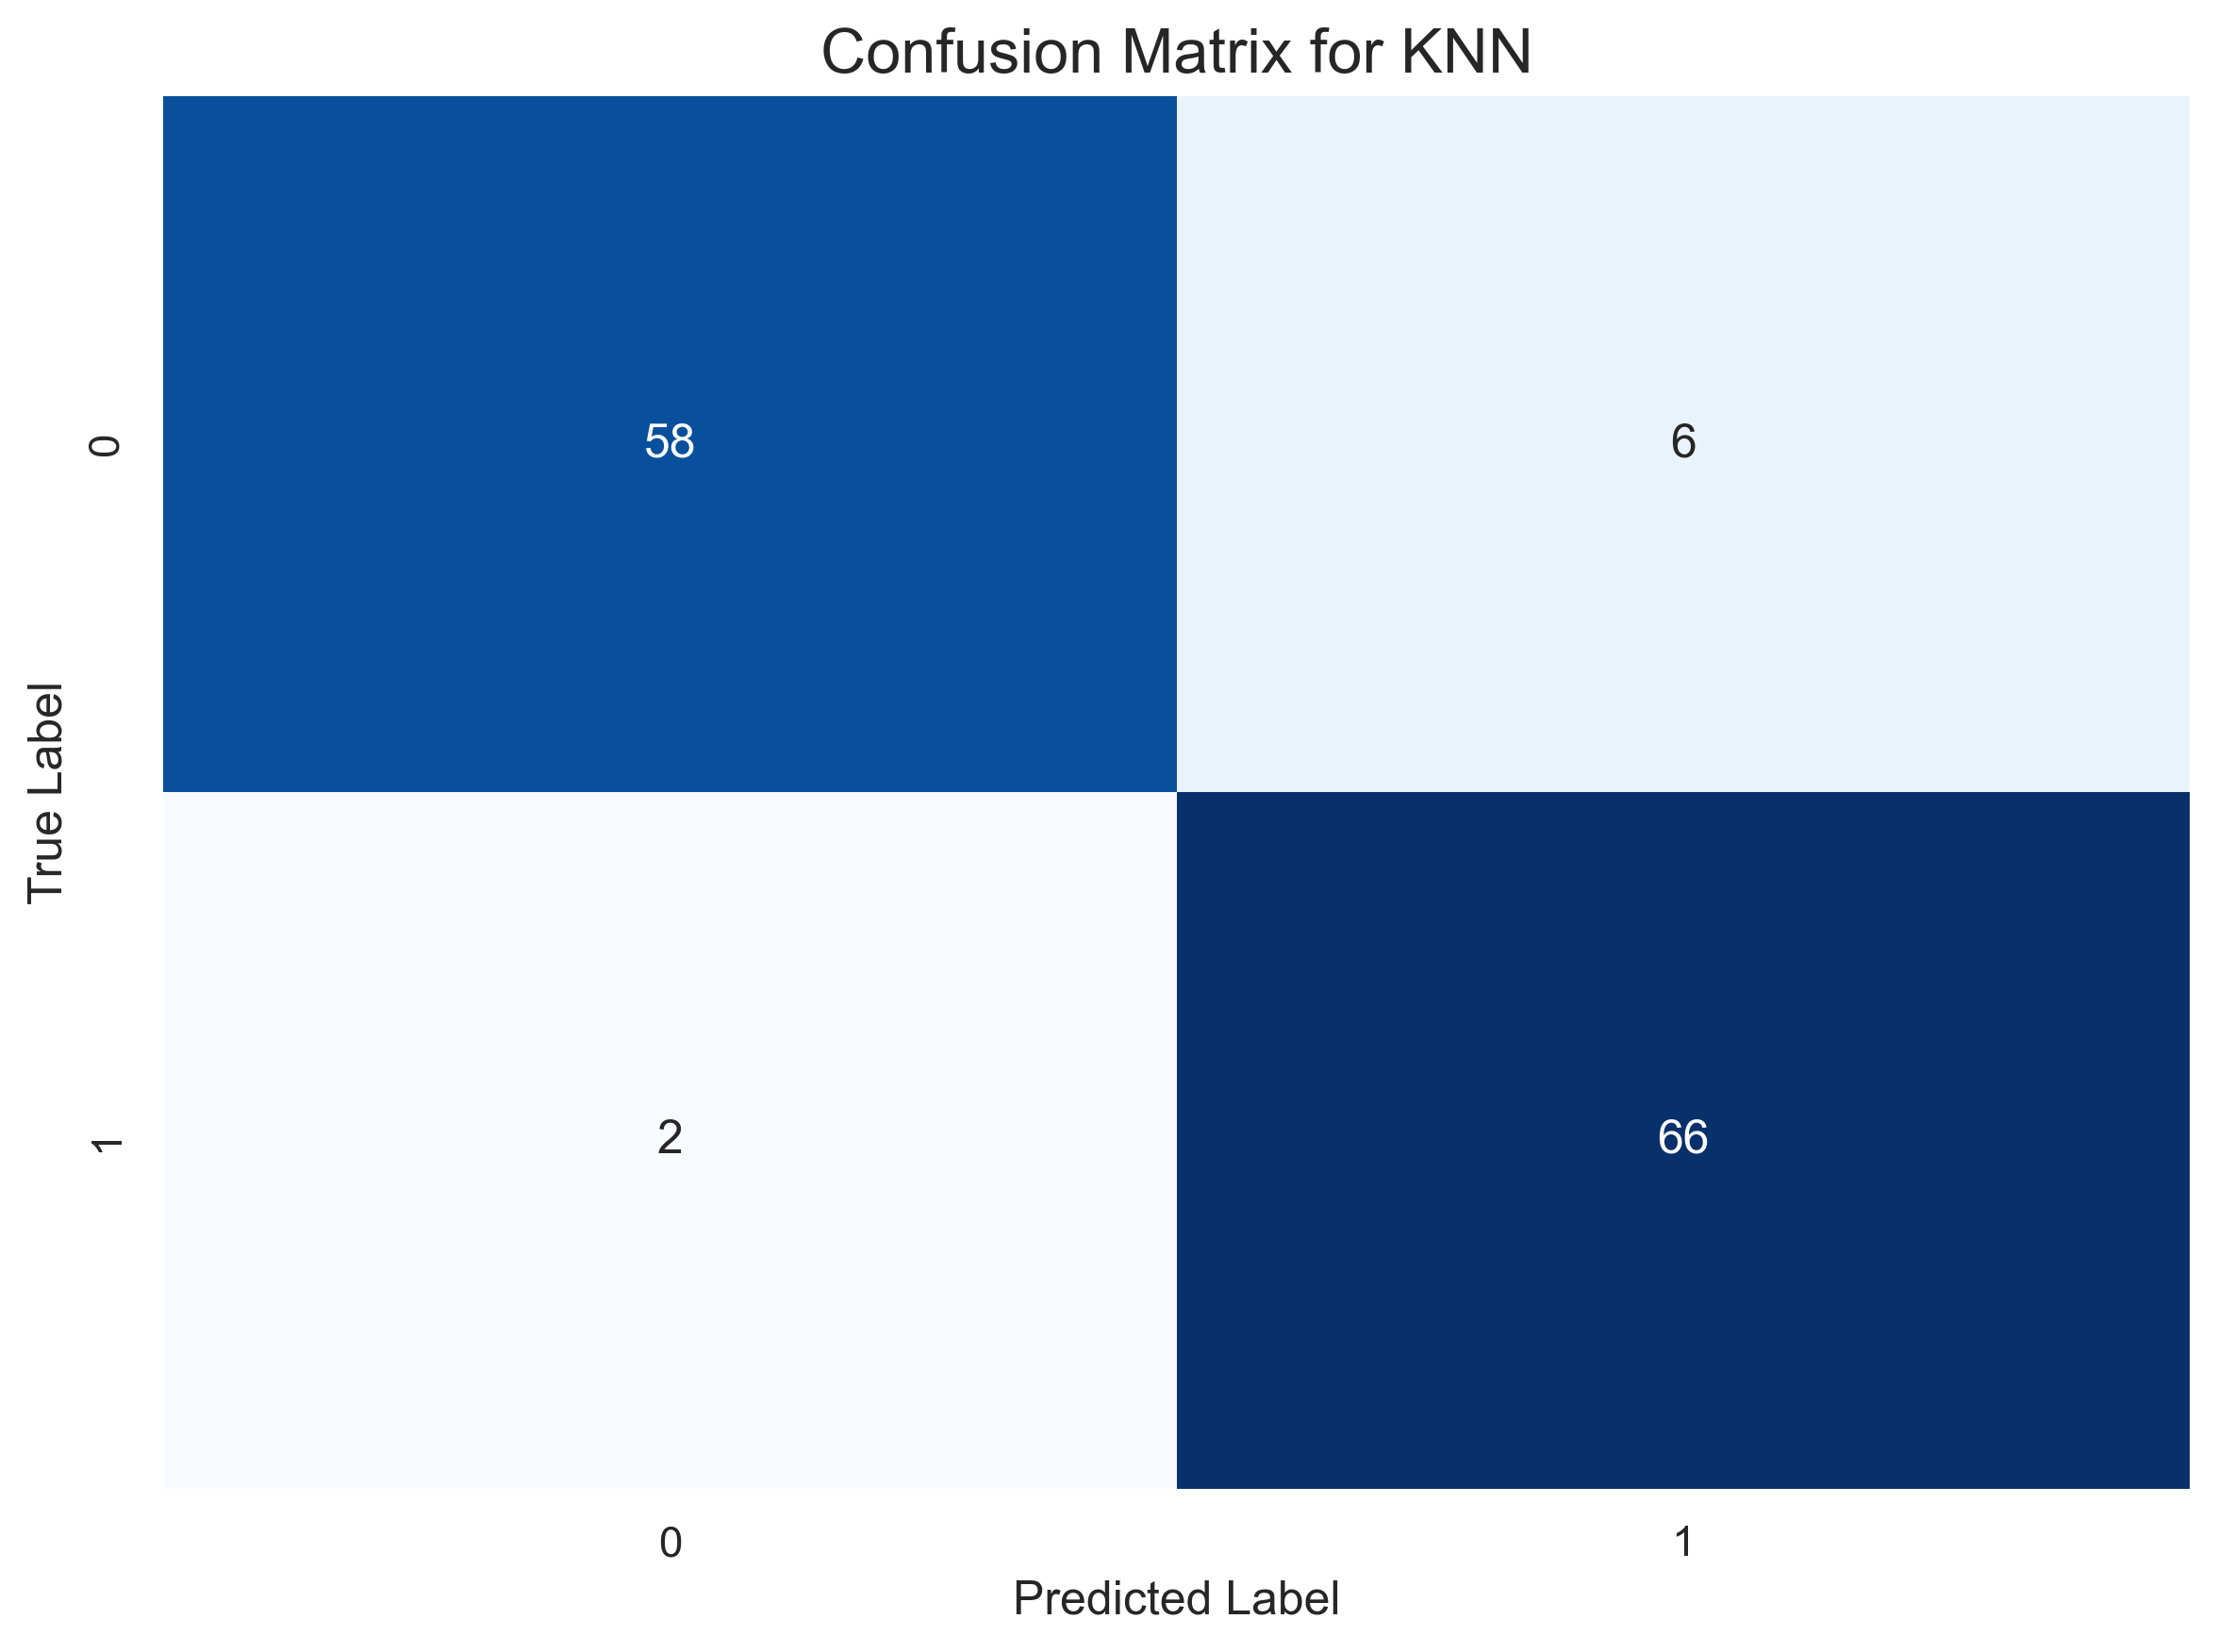

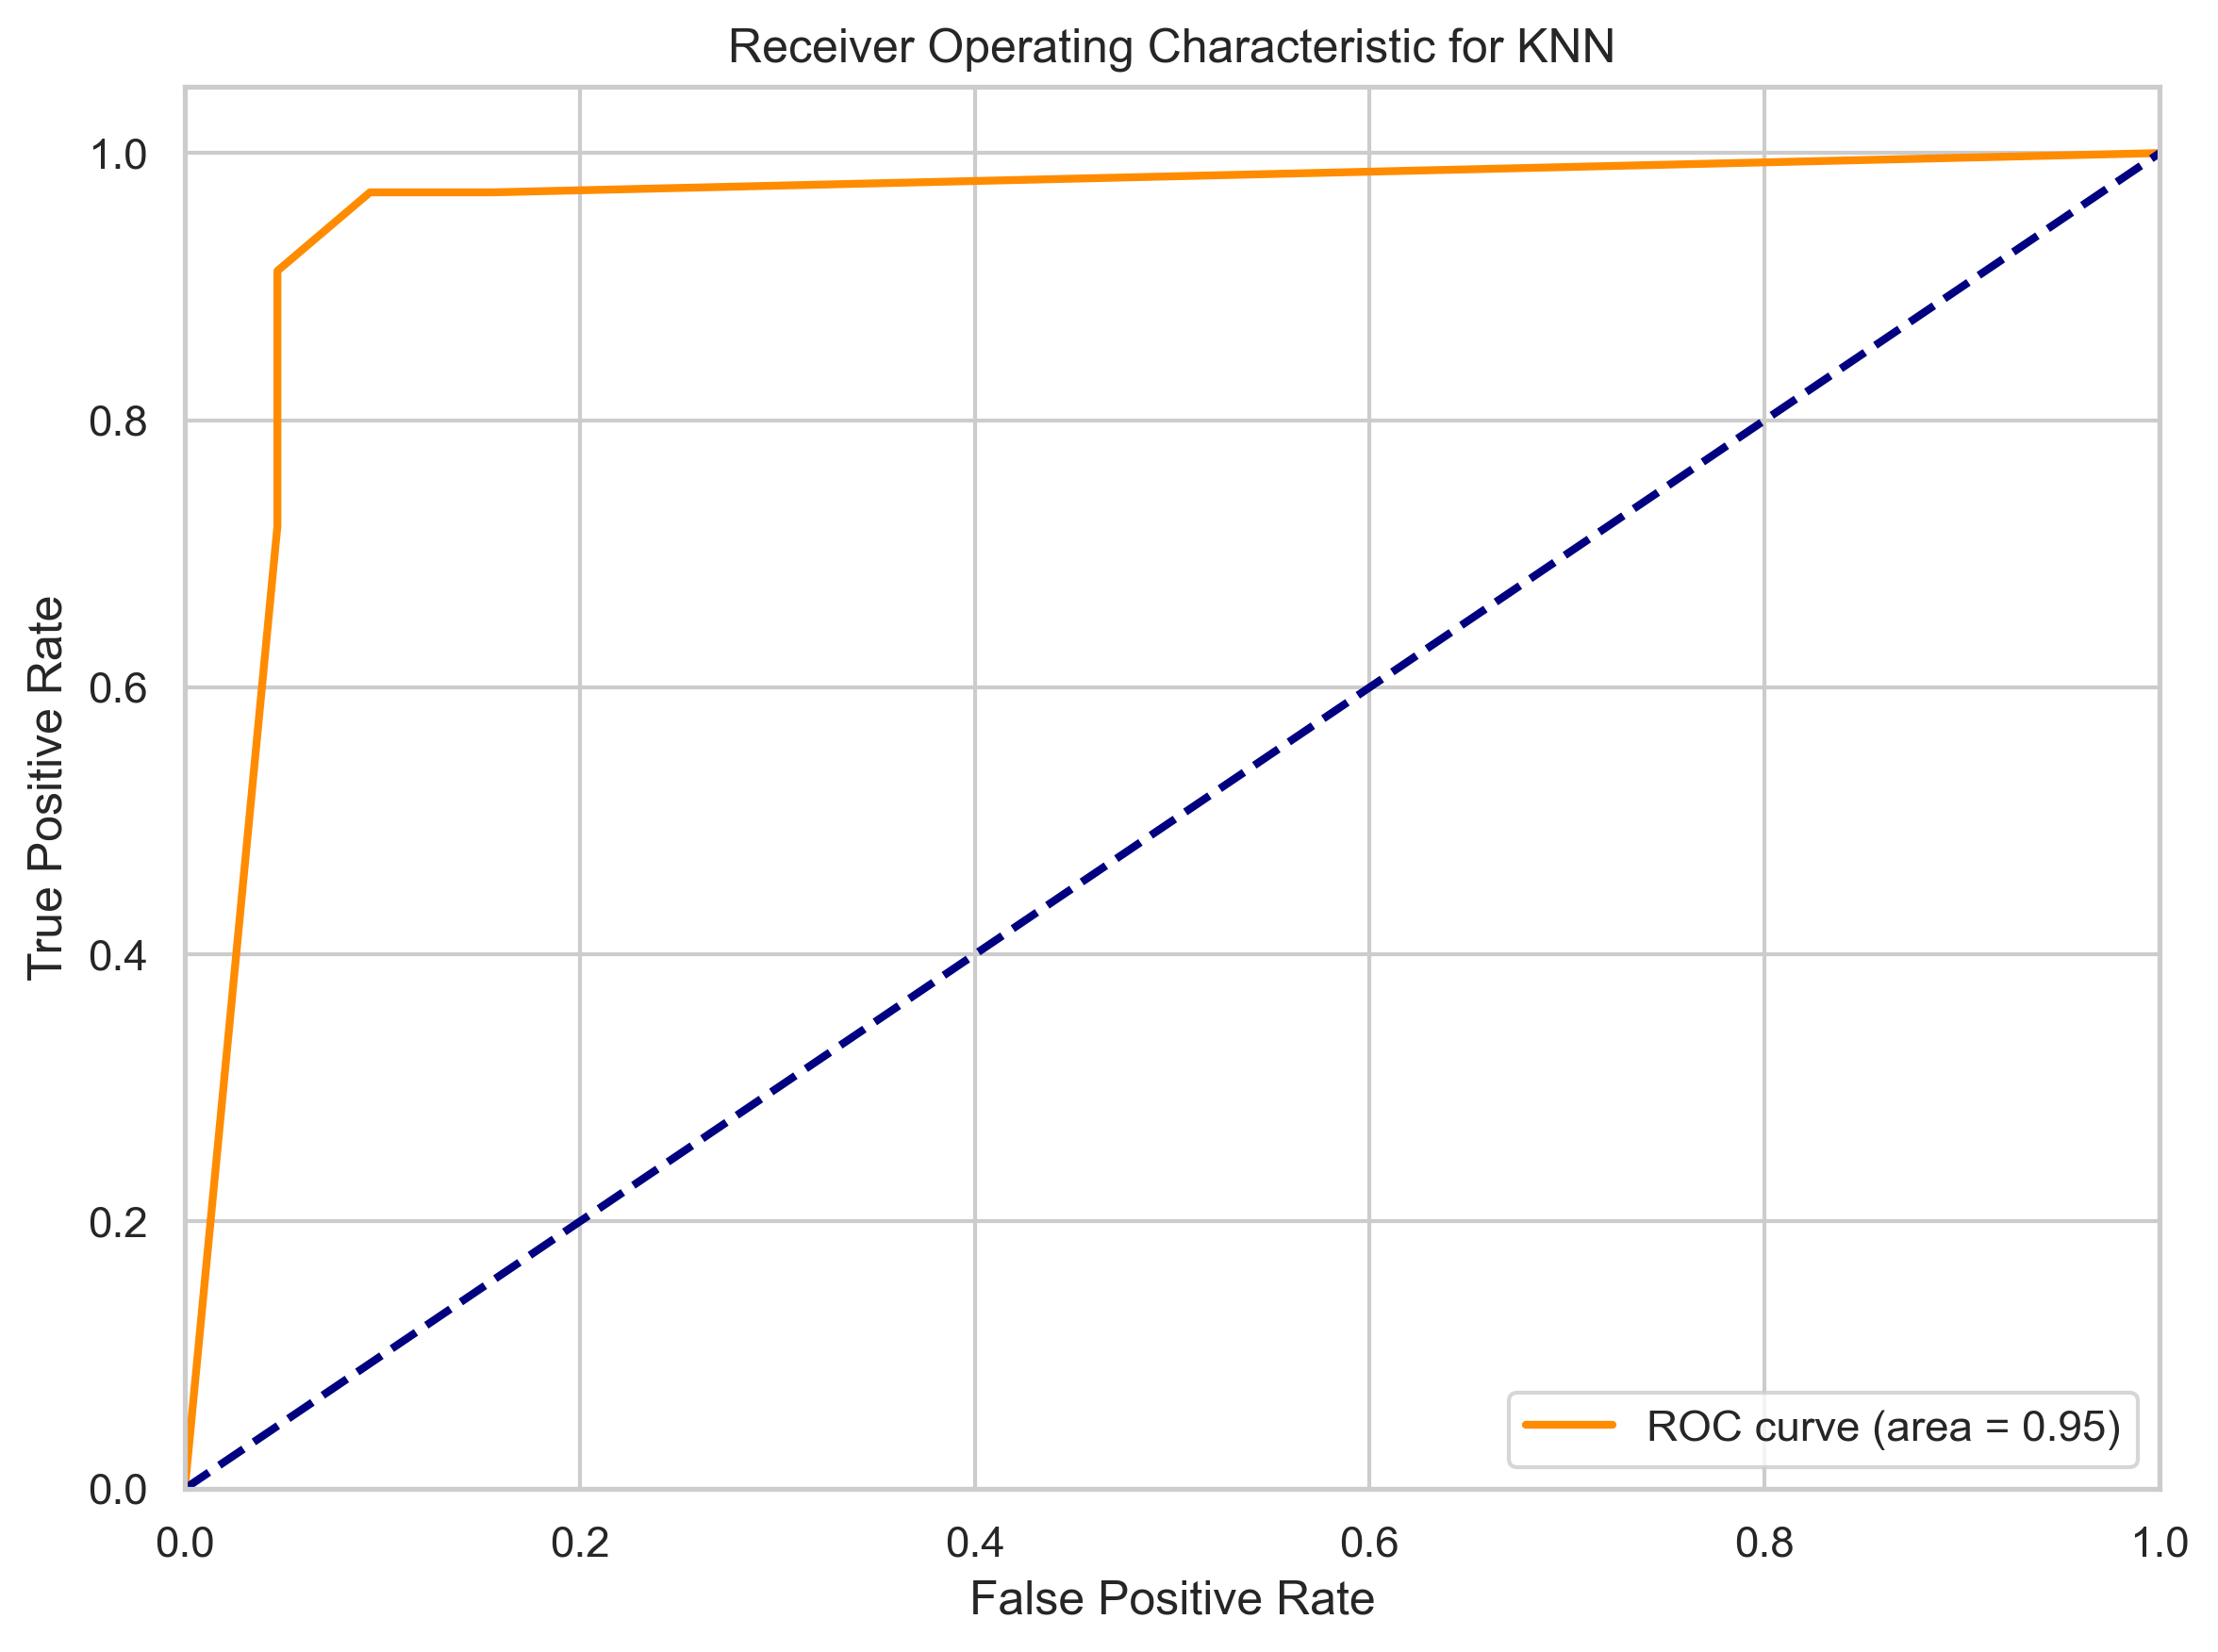

Classification Report:
               precision    recall  f1-score   support

           0      0.967     0.906     0.935        64
           1      0.917     0.971     0.943        68

    accuracy                          0.939       132
   macro avg      0.942     0.938     0.939       132
weighted avg      0.941     0.939     0.939       132



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)
print_classification_metrics(y_test, y_pred, y_pred_proba)

plot_confusion_matrix(y_test, y_pred, "KNN")
plot_roc_curve(y_test, y_pred_proba, "KNN")

report = classification_report(y_test, y_pred, digits=3)
print("Classification Report:\n", report)

# AdaBoost

Precision: 0.929
Recall: 0.956
F1 Score: 0.942
AUC: 0.955


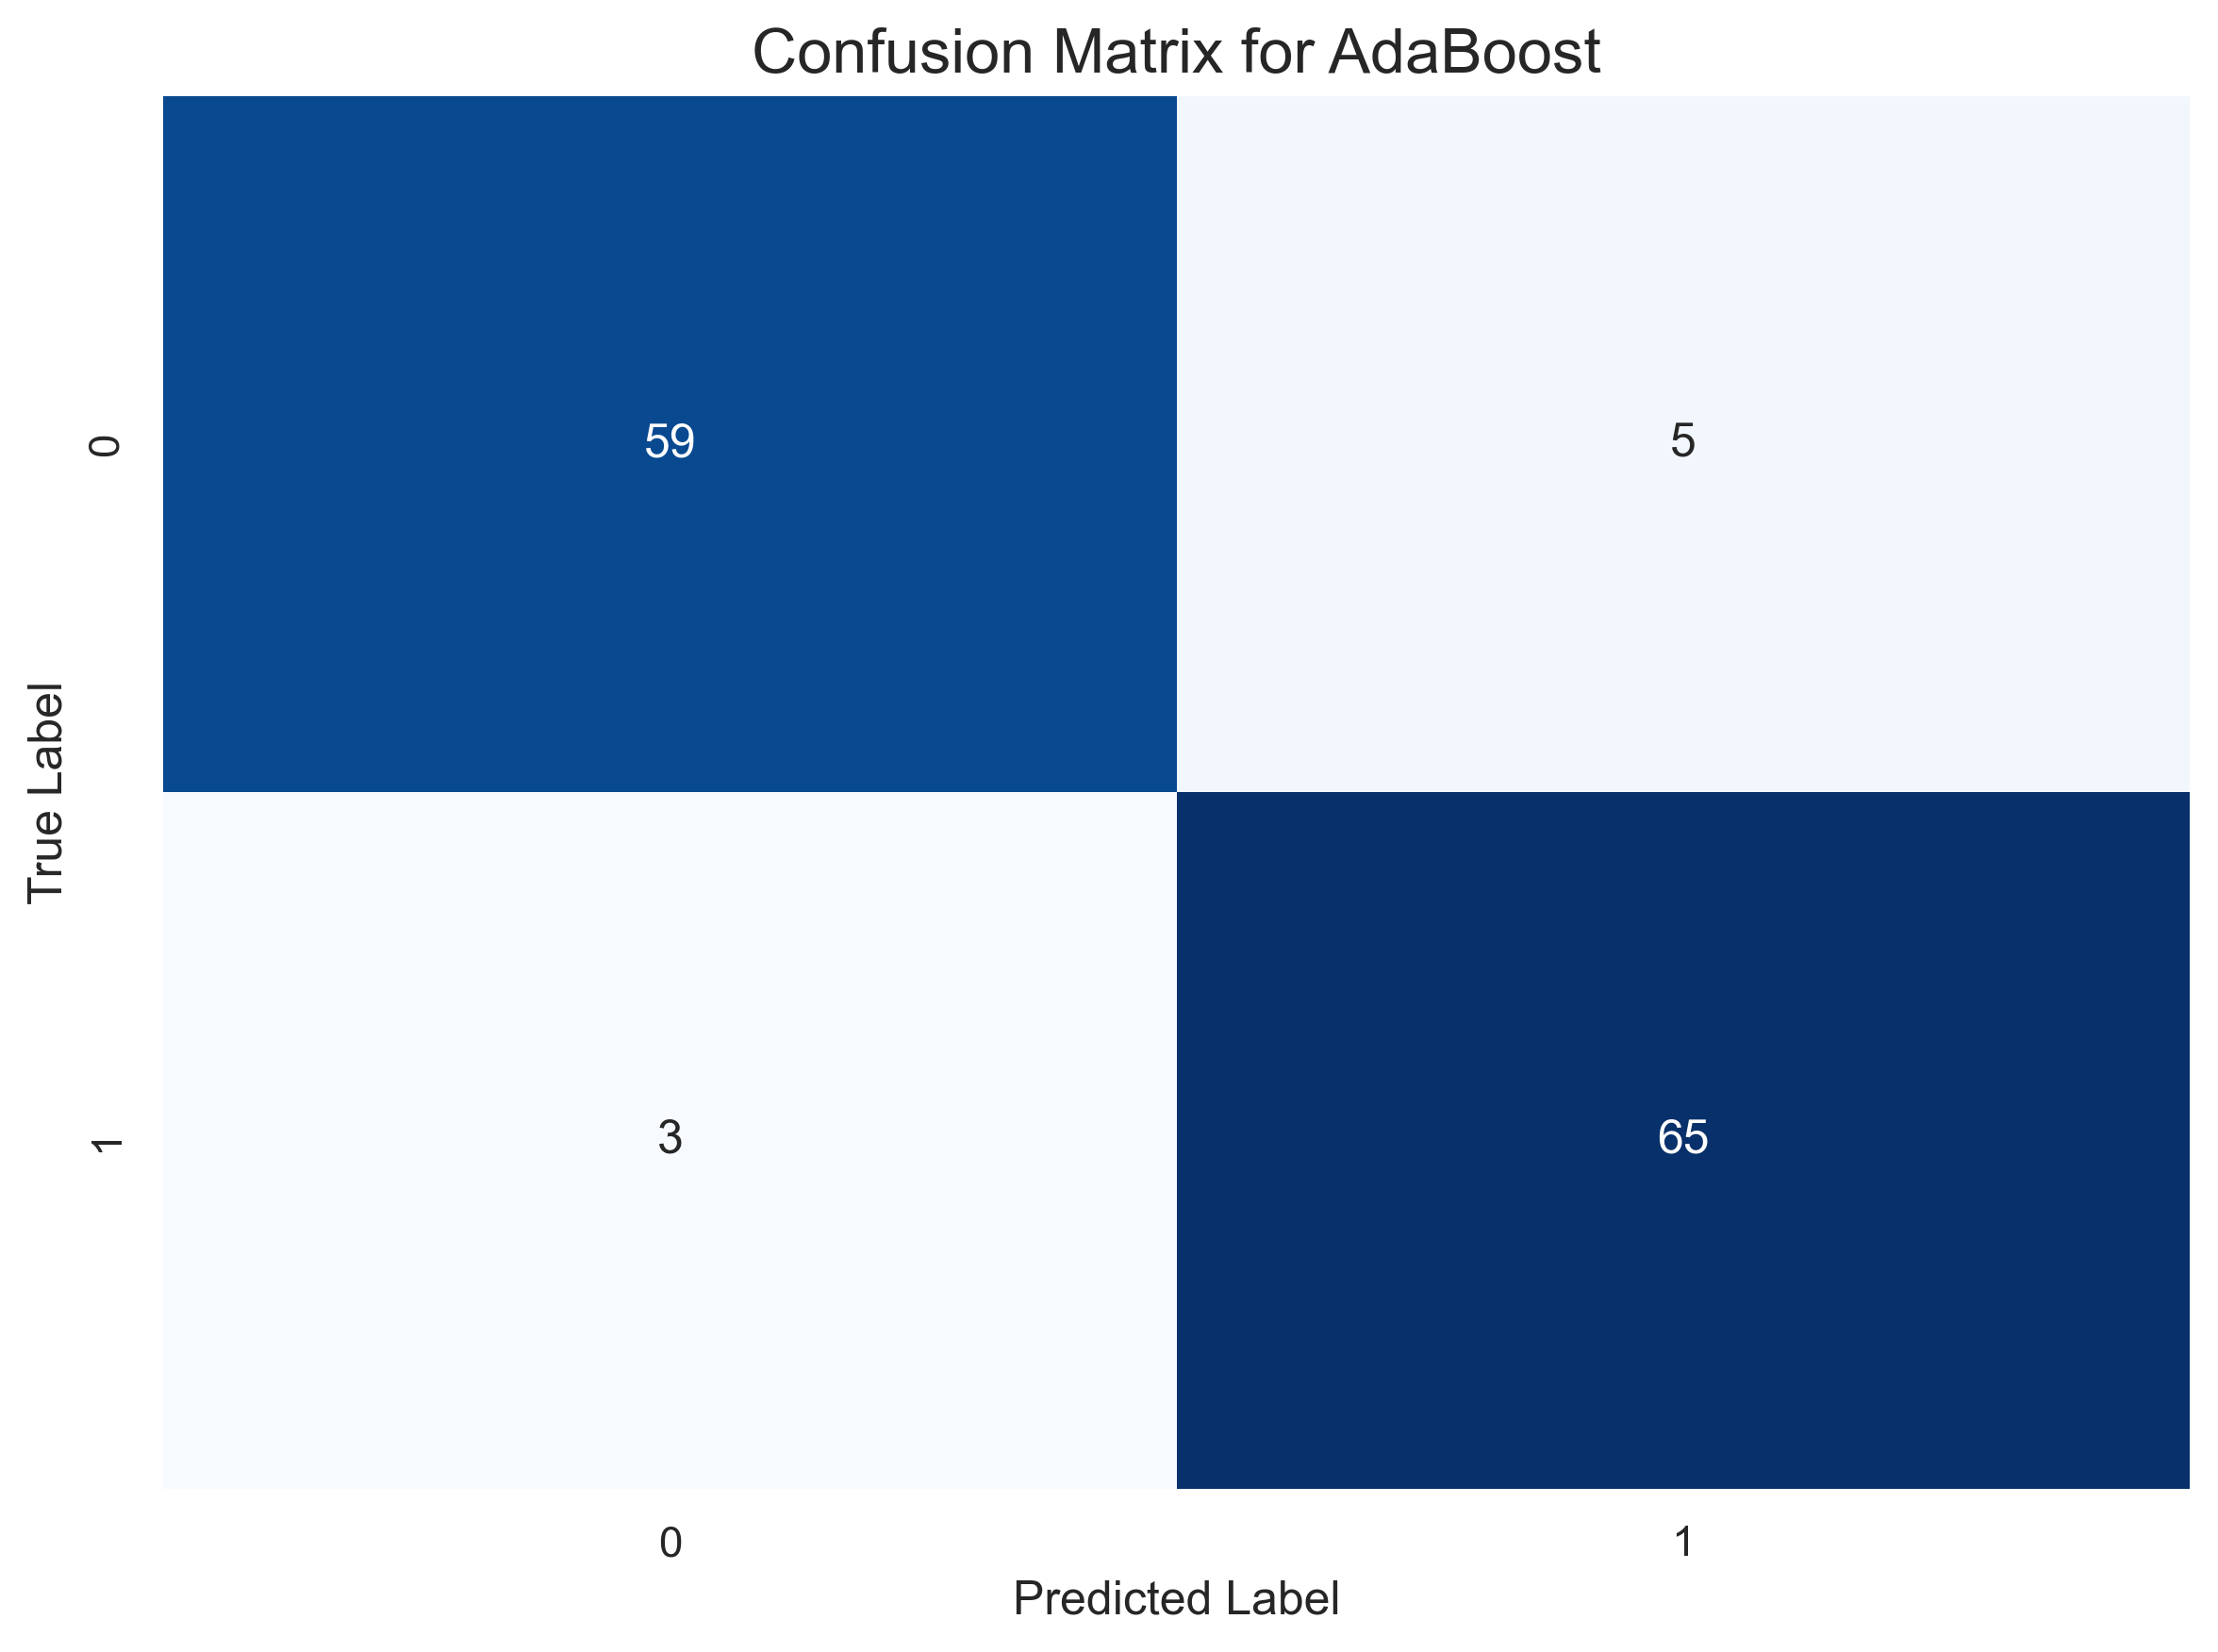

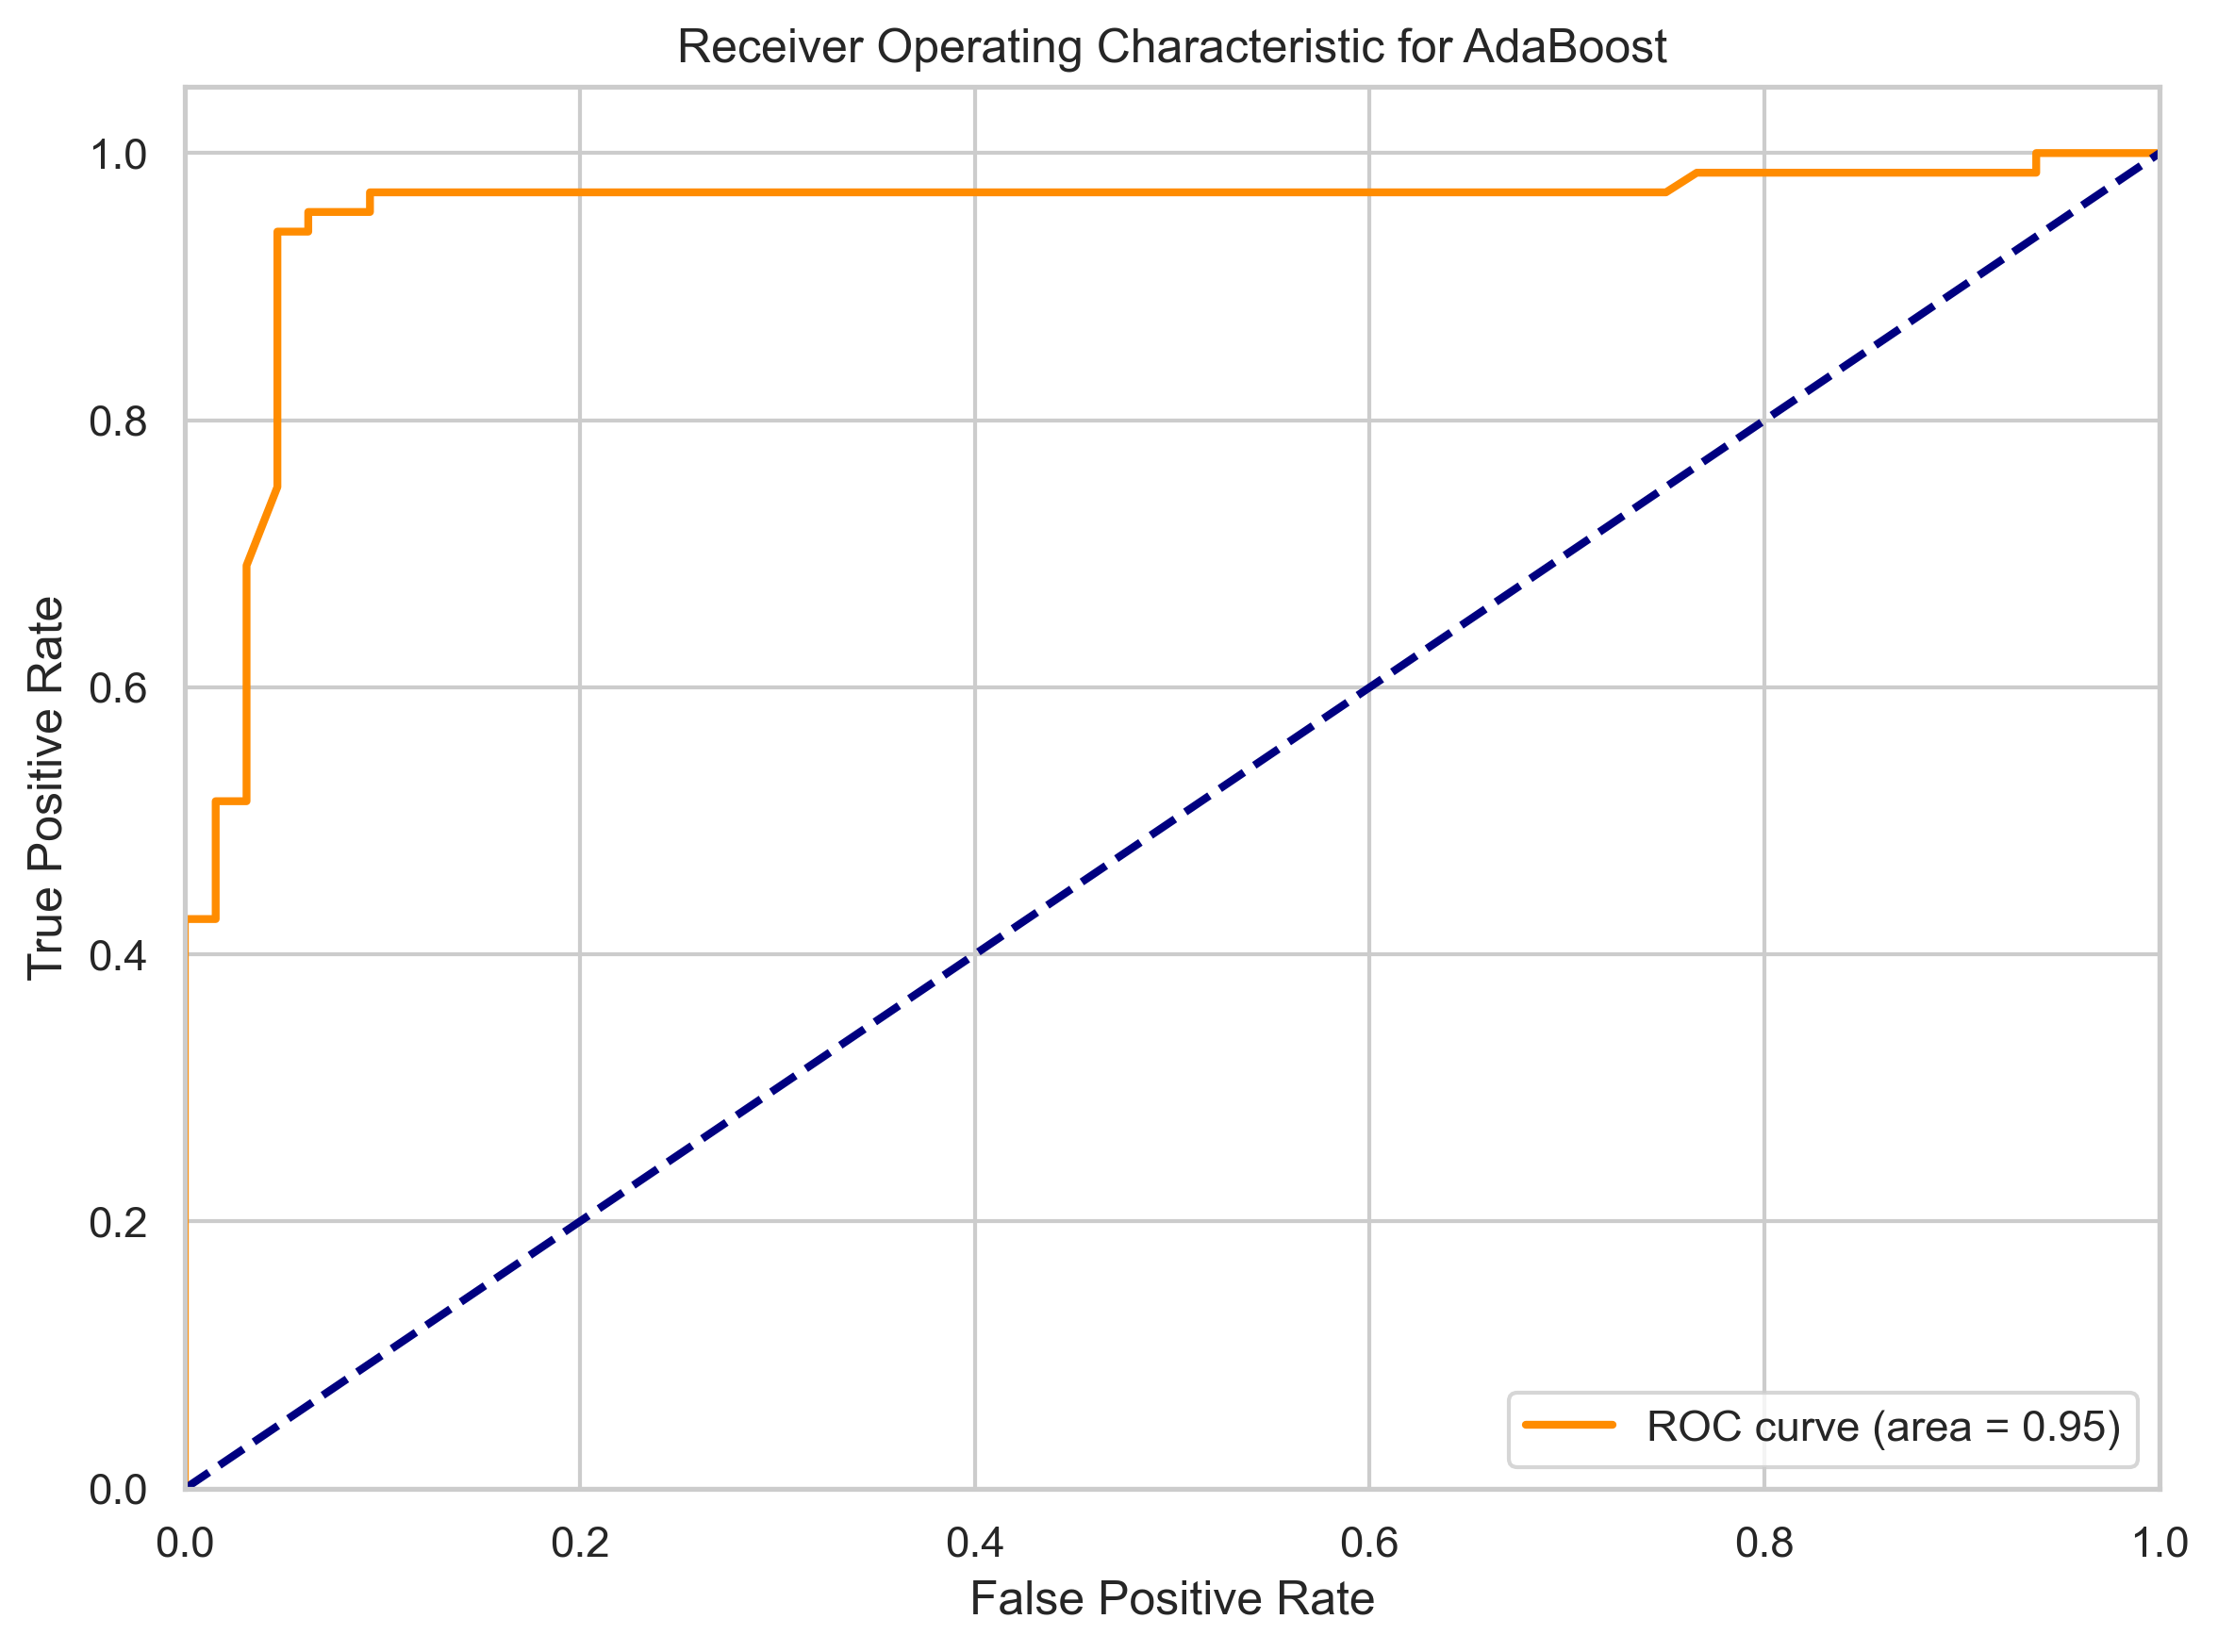

Classification Report:
               precision    recall  f1-score   support

           0      0.952     0.922     0.937        64
           1      0.929     0.956     0.942        68

    accuracy                          0.939       132
   macro avg      0.940     0.939     0.939       132
weighted avg      0.940     0.939     0.939       132



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

y_pred = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)
print_classification_metrics(y_test, y_pred, y_pred_proba)

plot_confusion_matrix(y_test, y_pred, "AdaBoost")
plot_roc_curve(y_test, y_pred_proba, "AdaBoost")

report = classification_report(y_test, y_pred, digits=3)
print("Classification Report:\n", report)


# Log Reg

Precision: 0.957
Recall: 0.971
F1 Score: 0.964
AUC: 0.955


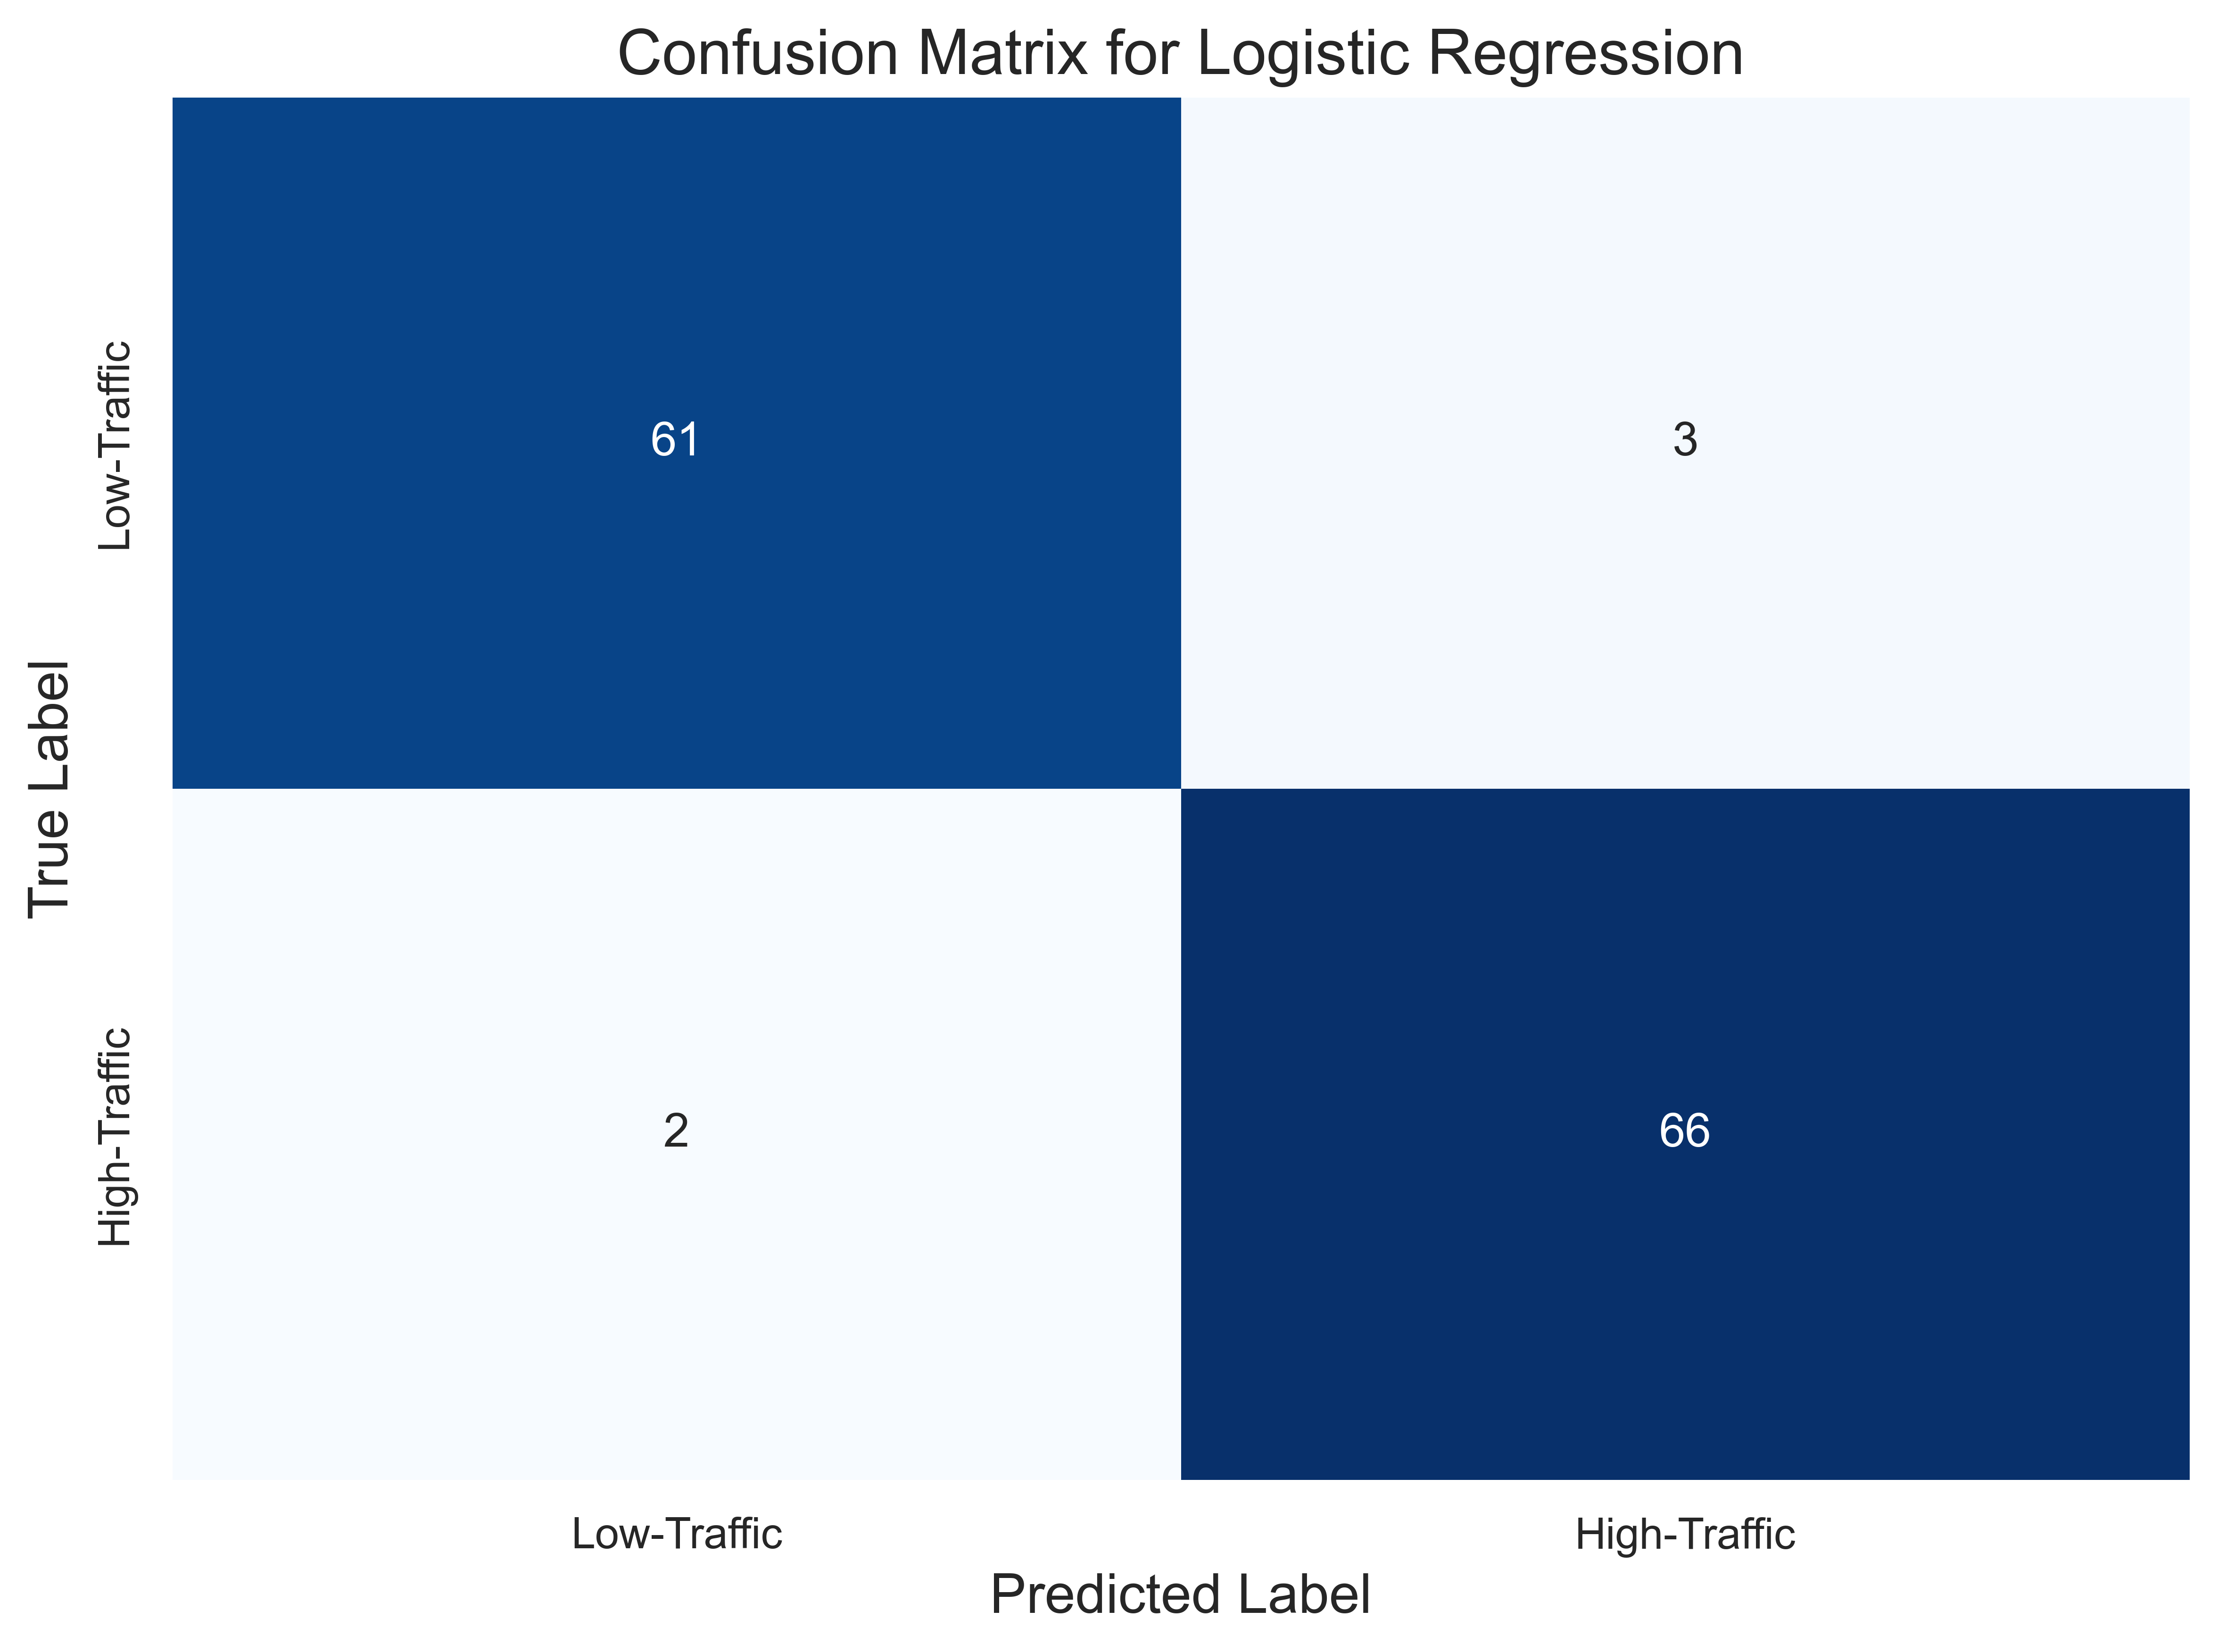

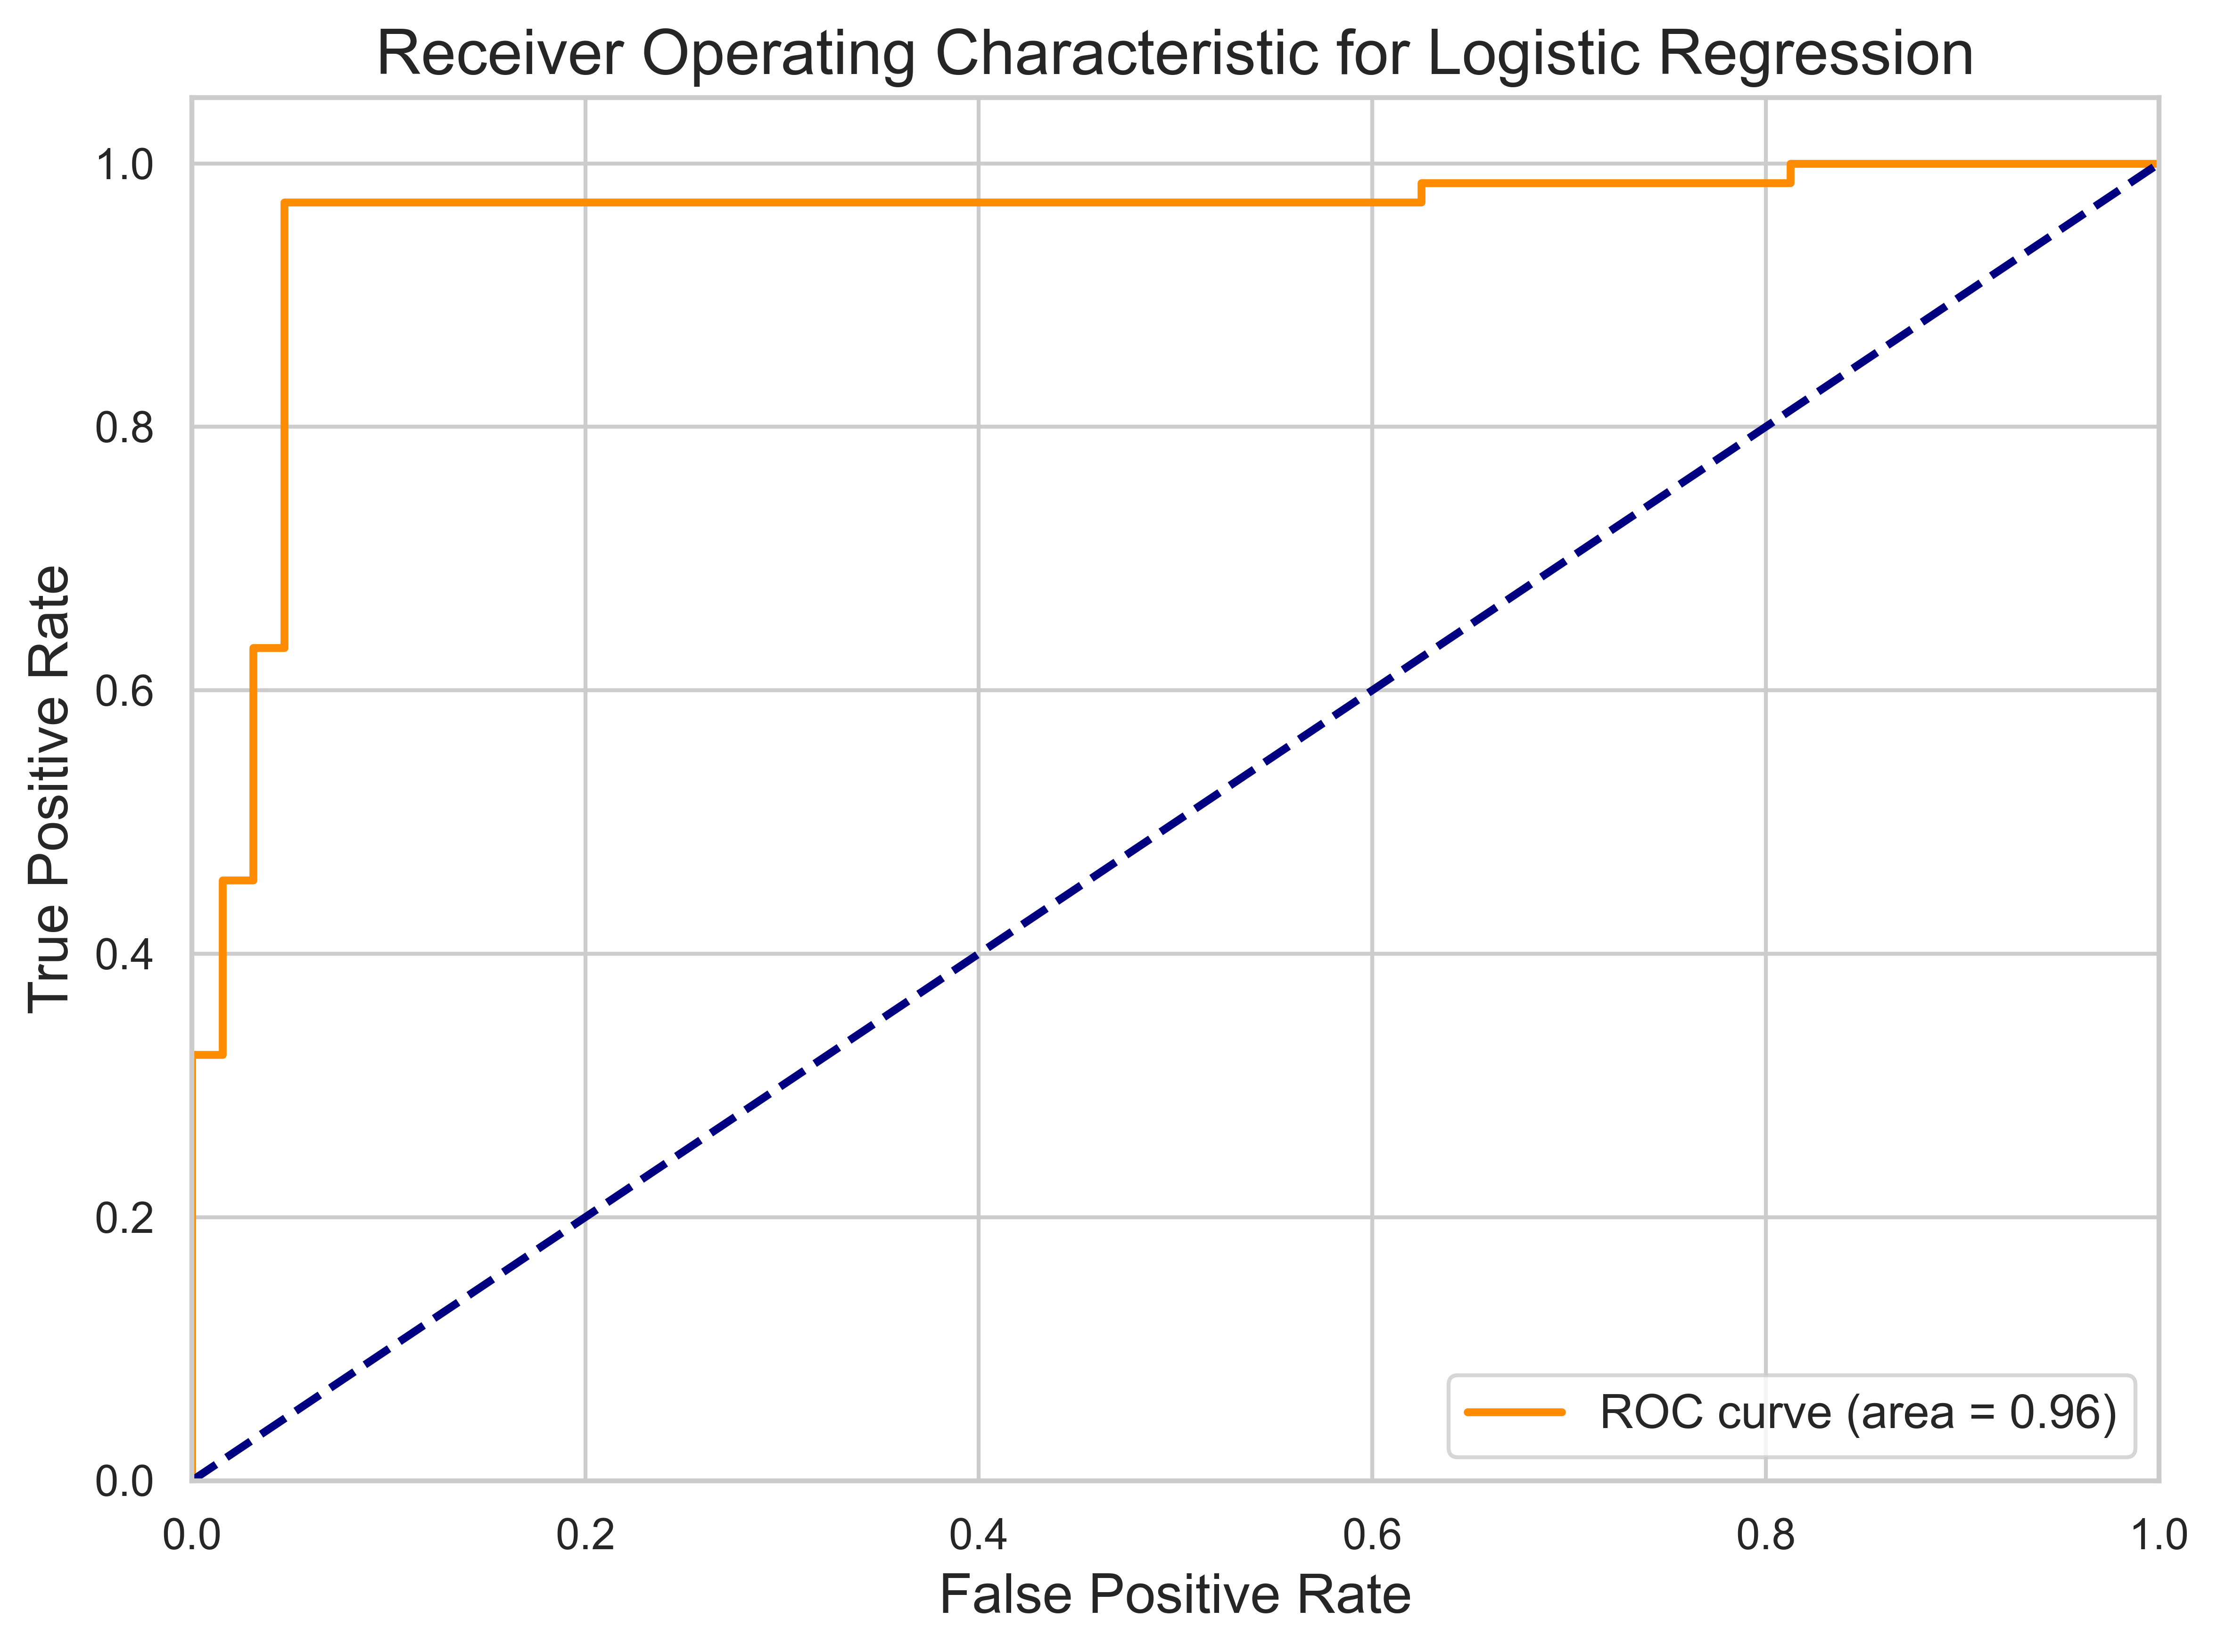

Classification Report:
               precision    recall  f1-score   support

           0      0.968     0.953     0.961        64
           1      0.957     0.971     0.964        68

    accuracy                          0.962       132
   macro avg      0.962     0.962     0.962       132
weighted avg      0.962     0.962     0.962       132



In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(solver='liblinear', random_state=42)
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)
y_pred_proba = log_reg_model.predict_proba(X_test)
print_classification_metrics(y_test, y_pred, y_pred_proba)

plot_confusion_matrix(y_test, y_pred, "Logistic Regression")
plot_roc_curve(y_test, y_pred_proba, "Logistic Regression")

report = classification_report(y_test, y_pred, digits=3)
print("Classification Report:\n", report)
